# Love and Relationships in British Novels of the Nineteenth Century

In [1]:
import pandas as pd
import requests
import string
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

from SPARQLWrapper import SPARQLWrapper, JSON
import ssl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from os.path import join
import re
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd


try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


The list below firsty identifies a number of notable British authors from the Nineteenth Century. 

In [2]:
author_names = [
'Jane Austen',
'Emily Brontë',
'Frances Burney',
'Charlotte Brontë',
'Mary Shelley',
'William Makepeace Thackeray',
'Edward Bulwer-Lytton',
'Robert Louis Stevenson',
'Walter Scott',
'Wilkie Collins',
'Henry James',
'Samuel Butler',
'Fanny Elizabeth Bunnett',
'Ouida',
'Anthony Trollope',
'William Harrison Ainsworth',
'George Eliot',
'Lewis Carroll',
'Anna Sewell',
'Thomas Hardy',
'Charles Dickens'    
]

The query below collects information about the books that have been written by each of these authors. The query returns the titles and the dates of publication. 

In [3]:
all_data = []

for author in author_names:

    query = '''
    SELECT DISTINCT ?book ?bookLabel ?authorLabel ?publicationDate
    {
      ?author rdfs:label "'''+author+'''"@en .
      ?book wdt:P50 ?author .

      OPTIONAL {
        ?book wdt:P577 ?publicationDate .
      }
      SERVICE wikibase:label {
        bd:serviceParam wikibase:language "en" .
      }
    } 
    '''

    endpoint = 'https://query.wikidata.org/sparql'
    sparql = SPARQLWrapper(endpoint)

    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    data = sparql.query().convert()

    df = pd.json_normalize(data['results']['bindings'])

    for i,row in df.iterrows():
        bookdata = []
        bookdata.append(row['book.value'])
        bookdata.append(row['bookLabel.value'])
        bookdata.append(row['authorLabel.value'])
        bookdata.append(row['publicationDate.value'])
        all_data.append(bookdata)

In [4]:
def format_filename(text):
    file_name = re.sub(r'[{}]'.format(string.punctuation),'',text)
    file_name = re.sub(r'\s+','_',file_name).lower().strip()
    return file_name

The dataset that is results is divided into two subgroups: (1) books published before 1845 and (2) books published after 1855. 

In [17]:
books = pd.DataFrame(all_data,columns=['qid','title','author','year'])

books = books[~books['title'].astype(str).str.startswith('Q')]
books = books[~books['year'].astype(str).str.startswith('http')]
books = books.dropna()
books['year'] = pd.to_datetime(books['year']).dt.year
books = books.query( 'year>=1800 and year<1900' )

books_early19c = books.query( 'year<=1845' )
books_late19c = books.query( 'year>=1850' )

In [6]:
early19c = [title.lower().strip() for title in list(books_early19c['title'])]
early19c = list(set(early19c))
late19c = [title.lower().strip() for title in list(books_late19c['title'])]
late19c = list(set(late19c))

book_year = dict()
for i,row in books.iterrows():
    book_year[format_filename(row['title'])] = row['year']

The cells below aim to establish whether the titles are also available on Project Gutenberg.

In [7]:
metadata_url = 'https://raw.githubusercontent.com/peterverhaar/introduction_to_dh/main/gutenberg_metadata.csv'
response = requests.get(metadata_url)
if response:
    with open('gutenberg.csv','w',encoding='utf-8') as out:
        out.write(response.text)

gb = pd.read_csv('gutenberg.csv')
gb = gb.query( 'language == "en"')
gb = gb.drop_duplicates( subset=['title'])

In [8]:
def remove_pg_boilerplate(complete_file):
    
    lines = re.split( r'\n' , complete_file )
    read_mode = 0 
    full_text = ''
    
    for line in lines:
        #print(line)
        if read_mode == 1:
            full_text += line + '\n'
            
        if re.search( r'\*{3,}\s+START\s+OF\s+TH(E|IS)\s+PROJECT\s+GUTENBERG\s+EBOOK' ,  str(line) , re.IGNORECASE ):
            read_mode = 1
        if re.search( r'\*{3,}\s+END\s+OF\s+TH(E|IS)\s+PROJECT\s+GUTENBERG\s+EBOOK' ,  str(line) , re.IGNORECASE ):
            read_mode = 0
            
    full_text = full_text.strip()
    if re.search( r'^Produced by' , full_text , re.IGNORECASE ):
        full_text = full_text[ full_text.index('\n') : len(full_text) ]
    return full_text

We download 30 texts from each of the two subgroups.

In [9]:
dir = 'PG_texts'
if not os.path.exists(dir):
    os.makedirs(dir)

count = 0
    
for i,row in gb.iterrows():
    title = row['title']
    file_name = re.sub(r'[{}]'.format(string.punctuation),'',title)
    file_name = re.sub(r'\s+','_',file_name).lower().strip()
    
    file_name = f'{file_name}.txt'
    
    if title.lower().strip() in early19c:
        count += 1
        if count == 30:
            break
        url = row['url']
        path = join(dir,file_name)
        response = requests.get(url)
        response.encoding = 'utf-8'
        out = open( path , mode='w',encoding= 'utf-8' )
        out.write( remove_pg_boilerplate(response.text) )
        out.close()
        print(f'{title} - downloaded.')
    
   

Persuasion - downloaded.
Northanger Abbey - downloaded.
Mansfield Park - downloaded.
Emma - downloaded.
Sense and Sensibility - downloaded.
The Bride of Lammermoor - downloaded.
The Pickwick Papers - downloaded.
American Notes - downloaded.
The Old Curiosity Shop - downloaded.
Oliver Twist - downloaded.
Sunday Under Three Heads - downloaded.
Nicholas Nickleby - downloaded.
Martin Chuzzlewit - downloaded.
Pride and Prejudice - downloaded.
The Talisman - downloaded.
The Black Dwarf - downloaded.
A Legend of Montrose - downloaded.
The Last Days of Pompeii - downloaded.
Kenilworth - downloaded.
Guy Mannering - downloaded.
Zanoni - downloaded.
Windsor Castle - downloaded.
The Lady of the Lake - downloaded.
Marmion: A Tale Of Flodden Field - downloaded.
The Fortunes of Nigel - downloaded.
Peveril of the Peak - downloaded.
The Monastery - downloaded.
The Abbot - downloaded.
The Betrothed - downloaded.


In [10]:
count = 0
for i,row in gb.iterrows():
    title = row['title']
    file_name = format_filename(title)
    
    file_name = f'{file_name}.txt'
    
    if title.lower().strip() in late19c:
        count += 1
        if count == 30:
            break
        url = row['url']
        path = join(dir,file_name)
        response = requests.get(url)
        response.encoding = 'utf-8'
        out = open( path , mode='w',encoding= 'utf-8' )
        out.write( remove_pg_boilerplate(response.text) )
        out.close()
        print(f'{title} - downloaded.')
    
print('Done!')

Through the Looking-Glass - downloaded.
Far from the Madding Crowd - downloaded.
A Tale of Two Cities - downloaded.
Treasure Island - downloaded.
The Return of the Native - downloaded.
The Mayor of Casterbridge - downloaded.
Middlemarch - downloaded.
Jude the Obscure - downloaded.
The Moonstone - downloaded.
The Haunted Hotel: A Mystery of Modern Venice - downloaded.
Roderick Hudson - downloaded.
Confidence - downloaded.
The Europeans - downloaded.
The Turn of the Screw - downloaded.
An International Episode - downloaded.
The Aspern Papers - downloaded.
A Pair of Blue Eyes - downloaded.
Black Beauty - downloaded.
The Merry Men and Other Tales and Fables - downloaded.
Weir of Hermiston: An Unfinished Romance - downloaded.
Memories and Portraits - downloaded.
Edinburgh: Picturesque Notes - downloaded.
Ballads - downloaded.
Kidnapped - downloaded.
Underwoods - downloaded.
The Woodlanders - downloaded.
Songs of Travel and Other Verses - downloaded.
Adam Bede - downloaded.
The Silverado Squ

## Searching with a lexicon

We make use of a lexicon containing words that have to do with love and relationships. Next, we count how often any of these words are used in each of the the 60 books. 

In [18]:
lexicon = []
lexicon_file = open('love_lexicon',encoding='utf-8')
for term in lexicon_file:
    lexicon.append(term.strip())
    
lexicon = [term.lower() for term in lexicon]

In [19]:
total_counts = dict()
nr_tokens = dict()

dir = 'PG_texts'

files = os.listdir(dir)
files = [join(dir,file) for file in files if not(re.search(r'^[.]',file))]

for file in files:
    
    title = os.path.basename(file)
    title = re.sub( r'[.]txt$' , '' , title )
    count = 0
    full_text = ''
    with open(file,encoding='utf-8') as file:
        full_text = file.read()
    words = word_tokenize(full_text.lower())
    word_freq = Counter(words)

    for word in word_freq.keys():
        
        if word in lexicon:
            count+=word_freq.get(word)
        
    total_counts[title] = count
    nr_tokens[title] = sum(word_freq.values())


KeyboardInterrupt: 

In [13]:
x_axis = list(total_counts.keys())
y_axis = list(total_counts.values())

early19c_f = [format_filename(text) for text in early19c]
late19c_f = [format_filename(text) for text in late19c]


hue = []
for title in x_axis:
    if title in early19c_f:
        hue.append('Early 19c')
    if title in late19c_f:
        hue.append('Late 19c')
        
        
df_dict = {'book':x_axis,'love_words':y_axis,'period':hue } 
   
df = pd.DataFrame(df_dict)


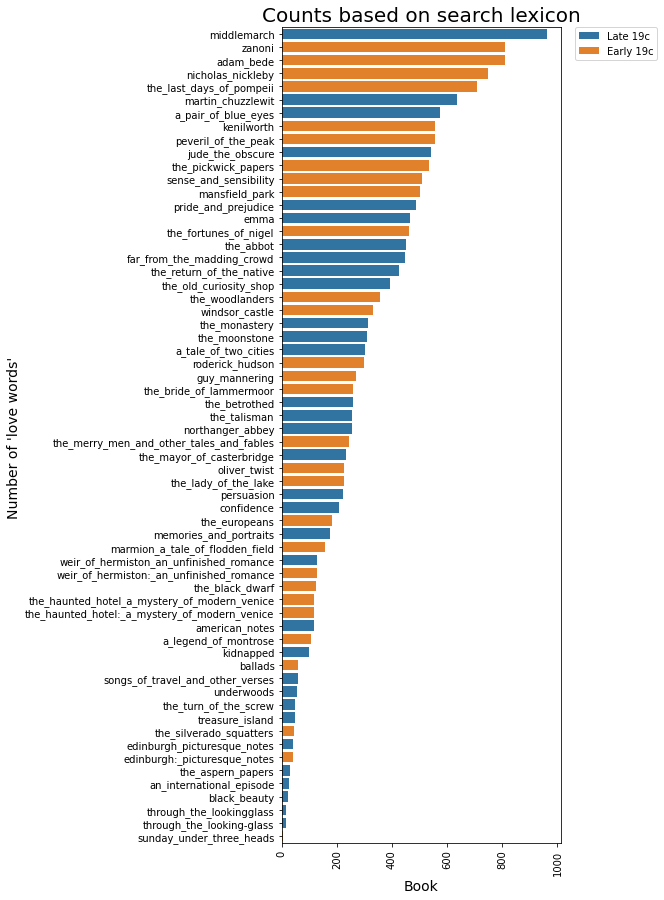

In [14]:
fig = plt.figure( figsize=( 5 , 15 ) )
df_sorted = df.sort_values(by=['love_words'] , ascending = False)

graph = sns.barplot( data=df_sorted,x='love_words', y='book' , hue='period' , dodge = False  )

graph.set_title('Counts based on search lexicon' , size = 20) 
graph.set_xlabel('Book' , size = 14) 
graph.set_ylabel('Number of \'love words\' ' , size = 14 )

plt.xticks(rotation= 90)
# The next line places the legend outside out the plot
plt.legend( bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.);


plt.show()

In [38]:
annual_count = dict()
nr_tokens = dict()

def count_tokens(title):
    count = 0
    word_freq = Counter()
    
    file_name = format_filename(title)
    file_name = join(dir,file_name)
    file_name = f'{file_name}.txt'
    
    if os.path.isfile(file_name):
    
        with open(file_name,encoding='utf-8') as file:
            full_text = file.read()

        
        words = word_tokenize(full_text.lower())
        word_freq.update(words)

        for word in word_freq.keys():

            if word in lexicon:
                count+=word_freq.get(word)

    return (count,sum(word_freq.values()))


for i,row in books_early19c.iterrows():
    result = count_tokens(row['title'])
    annual_count[row['year']] = annual_count.get(row['year'],0)+result[0]
    nr_tokens[row['year']] = nr_tokens.get(row['year'],0)+result[1]

for i,row in books_late19c.iterrows():
    result = count_tokens(row['title'])
    annual_count[row['year']] = annual_count.get(row['year'],0)+result[0]
    nr_tokens[row['year']] = nr_tokens.get(row['year'],0)+result[1]



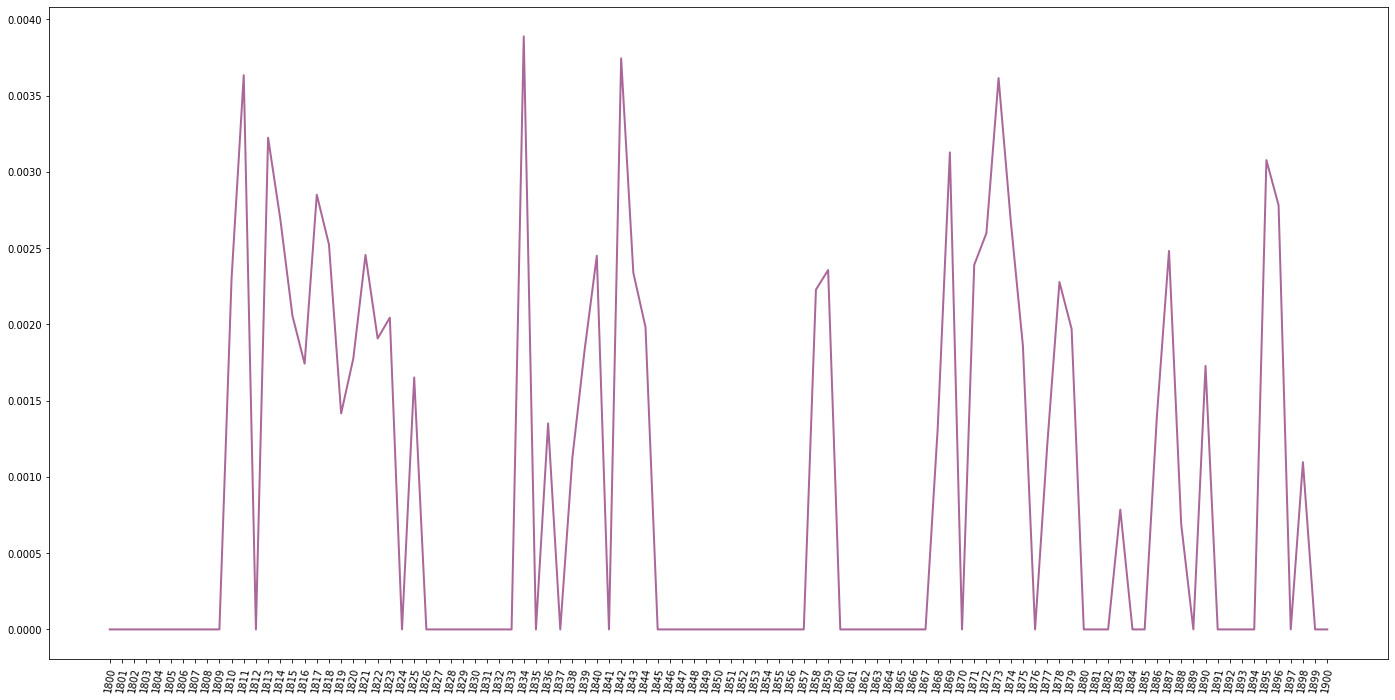

In [45]:
x_axis = []
y_axis = []

for year in range(1800,1901):
    x_axis.append(str(year))
    if nr_tokens.get(year,0)>0:
        value = annual_count.get(year)/nr_tokens.get(year)
        y_axis.append(value)
    else:
        y_axis.append(0)
    
fig = plt.figure( figsize = ( 24, 12))
ax = sns.lineplot( x= x_axis, y=y_axis, color= '#AA6799', 
                  linestyle='solid',linewidth=2 )
plt.xticks(rotation= 80)
plt.show()

## Collocation analysis

Which words are used in the vicinity of the words on the 'love lexicon'?

In [46]:
from nltk.corpus import stopwords
import string
stopword_list = stopwords.words('english')
stopword_list.extend(['”','“','’'])
for punct in string.punctuation:
    stopword_list.append(punct)

for file in files:
    collocations = Counter()
    other_words = []
    
    title = os.path.basename(file)
    title = re.sub( r'[.]txt$' , '' , title )
    print(f"\n{title}\n")

    full_text = ''
    with open(file,encoding='utf-8') as file:
        full_text = file.read()
    full_text = re.sub(r'\s+',' ',full_text)
    sentences = sent_tokenize(full_text)
    for sent in sentences:
        words = word_tokenize(sent)
        match = False
        for word in words:
            if word in lexicon:
                match = True
            if match:
                for word in words:
                    if word not in lexicon and word not in stopword_list and len(word)>2:
                        other_words.append(word)
    
    collocations = Counter(other_words)
    for word,count in collocations.most_common(10):
        print(f'{word} {count}')


the_turn_of_the_screw

little 376
would 153
never 151
face 100
see 98
The 94
could 92
wonder 91
took 81
got 81

the_moonstone

Mr. 966
said 633
Rachel 525
Franklin 469
The 457
first 454
lady 447
Miss 415
engagement 337
take 319

kenilworth

said 13400
Tressilian 6010
Leicester 5727
Varney 4742
thou 4367
Earl 4087
lord 3699
one 3563
would 3546
The 3028

confidence

Gordon 688
Bernard 432
Wright 293
Vivian 278
would 242
one 216
n't 213
friend 209
Angela 208
Blanche 196

martin_chuzzlewit

one 2396
Tom 2102
Pecksniff 1970
would 1940
upon 1679
said 1545
might 1528
could 1301
little 1205
Pinch 1154

weir_of_hermiston:_an_unfinished_romance

Hermiston 332
Elliotts 317
Kirstie 315
auld 258
man 229
could 201
gang 192
like 190
though 183
one 180

sunday_under_three_heads

upon 202
people 172
old 162
good 124
would 124
toil 124
day 124
month 124
pleasures 114
children 110

a_pair_of_blue_eyes

said 2149
Elfride 1896
would 1772
Knight 1522
Stephen 1485
man 1231
never 1222
And 1130
think 1043
say

In [47]:
for file in files:
    
    title = os.path.basename(file)
    title = re.sub( r'[.]txt$' , '' , title )
    print(f"\n{title}\n")

    full_text = ''
    with open(file,encoding='utf-8') as file:
        full_text = file.read()
    full_text = re.sub(r'\s+',' ',full_text)
    sentences = sent_tokenize(full_text)
    for sent in sentences:
        words = word_tokenize(sent)
        match = False
        for word in words:
            if word in lexicon:
                match = True
        if match:
            print(sent)


the_turn_of_the_screw

I took that _here_”—he tapped his heart.
Yes, she was in love.
“Who was it she was in love with?” “The story will tell,” I took upon myself to reply.
“Well, if I don’t know who she was in love with, I know who _he_ was.” “She was ten years older,” said her husband.
But as my little conductress, with her hair of gold and her frock of blue, danced before me round corners and pattered down passages, I had the view of a castle of romance inhabited by a rosy sprite, such a place as would somehow, for diversion of the young idea, take all color out of storybooks and fairytales.
She expressed in her little way an extraordinary detachment from disagreeable duties, looking to me, however, with a great childish light that seemed to offer it as a mere result of the affection she had conceived for my person, which had rendered necessary that she should follow me.
I needed nothing more than this to feel the full force of Mrs. Grose’s comparison, and, catching my pupil in my 

It made no serious impression on any of us except my cousin—whose love of the marvellous induced him to believe it.
It was in the court outside the treasury that my cousin and I met, to enforce the laws of discipline on our own soldiers.
There I lived till Miss Julia married the late Sir John Verinder.
An excellent man, who only wanted somebody to manage him; and, between ourselves, he found somebody to do it; and what is more, he throve on it and grew fat on it, and lived happy and died easy on it, dating from the day when my lady took him to church to be married, to the day when she relieved him of his last breath, and closed his eyes for ever.
Pension him liberally, and let Gabriel Betteredge have his place.” On the Tuesday as it might be, Sir John says, “My lady, the bailiff is pensioned liberally; and Gabriel Betteredge has got his place.” You hear more than enough of married people living together miserably.
Selina Goby was all right in both these respects, which was one reason f

She next turned to Miss Rachel, and kissed her.
The worthy magistrate was an old friend of my lady’s, and the Indians were “committed” for a week, as soon as the court opened that morning.
The poor thing is breaking her heart about Mr. Franklin Blake.” Here was another view of the girl’s conduct.
As for me, I hadn’t even heart enough to open my _Robinson Crusoe_.
“I am Sergeant Cuff, miss, of the Detective Police.” “Do you think a young lady’s advice worth having?” “I shall be glad to hear it, miss.” “Do your duty by yourself—and don’t allow Mr Franklin Blake to help you!” She said those words so spitefully, so savagely, with such an extraordinary outbreak of ill-will towards Mr. Franklin, in her voice and in her look, that—though I had known her from a baby, though I loved and honoured her next to my lady herself—I was ashamed of Miss Rachel for the first time in my life.
My lady rallied a little after having opened her heart to me—being, naturally, a woman of a high courage, as I hav

“My lady’s love, Miss; and I was to say that you would find a letter inside.” Having given that message, the fresh-coloured young footman surprised me by looking as if he would have liked to run away.
All sent their love; and all expressed a cheering belief that Lady Verinder’s indisposition would soon pass away.” “_You_ don’t think it’s serious, do you, Godfrey?” “Far from it!
Successful love may sometimes use the language of flattery, I admit.
But hopeless love, dearest, always speaks the truth.” He drew his chair close, and took her hand, when he said “hopeless love.” There was a momentary silence.
Am I mad to dream of some future day when your heart may soften to me?
I must have _that_ to cherish, and to comfort me, if I have nothing else!” His voice trembled, and he put his white handkerchief to his eyes.
Suppose you were not in love with me?
Suppose you were in love with some other woman?” “Yes?” “Suppose you discovered that woman to be utterly unworthy of you?
Suppose the bare i

I love you.” The letter dropped from my hand.
I tell you plainly, I can’t find it in my heart to distress you, after what you have had to bear already.
I did these strange things, because I loved you.
You were like a lover in a dream.
I believe I found out you were in love with her, before you knew it yourself.
I was mad enough to love you; and I couldn’t even attract your notice.
I used to kiss the pillow on which your head had rested all night.
And, God help us all!” he added, in a lower tone, “it’s no less natural in _her_.” I proceed to copy the continuation of the letter from the original, in my own possession:— “Having determined to keep the nightgown, and to see what use my love, or my revenge (I hardly know which) could turn it to in the future, the next thing to discover was how to keep it without the risk of being found out.
if you have ever loved, you will understand how it was that all my courage cooled, when I walked into the room, and found myself in your presence.
Was su

Here was a chance of reading that domestic bit about the child which I had marked on the day of Mr. Franklin’s marriage!
What with the heat, and what with the vexation of the weather, neither officers nor men seemed to be in heart for their duty while the calm lasted.
Finding myself, for the second time, in these romantic regions, I resolved not to leave Kattiawar, without looking once more on the magnificent desolation of Somnauth.

kenilworth

But the almost general voice of the times attached the most foul suspicions to the death of the unfortunate Countess, more especially as it took place so very opportunely for the indulgence of her lover's ambition.
In the following extract of the passage, the reader will find the authority I had for the story of the romance:-- “At the west end of the church are the ruins of a manor, anciently belonging (as a cell, or place of removal, as some report) to the monks of Abington.
This, it seems, was proved by the report of Dr. Walter Bayly, sometim

“You are contented, then,” said Varney to his companion, “to take court service?” “Ay, worshipful sir, if you like my terms as well as I like yours.” “And what are your terms?” demanded Varney.
All paid court to Varney, with more or less deference, as suited their own rank, or the urgency of the business which brought them to his lord's levee.
“Now the Lord love his noble countenance!” said the bailiff, who had thrust himself into the presence-chamber; “he looks somewhat pale.
The Earl and his retinue took horse soon after to return to court, accompanied by the shouts of the inhabitants of Woodstock, who made the old oaks ring with re-echoing, “Long live Queen Elizabeth, and the noble Earl of Leicester!” The urbanity and courtesy of the Earl even threw a gleam of popularity over his attendants, as their haughty deportment had formerly obscured that of their master; and men shouted, “Long life to the Earl, and to his gallant followers!” as Varney and Lambourne, each in his rank, rode pr

I will have in this court, ay, and in this realm, but one mistress, and no master.
We will brook no mayor of the palace here.” Bowyer kissed the hand which she extended towards him, and withdrew to his post, astonished at the success of his own audacity.
You also must needs ruffle in the court of England, at the head of a faction of your own?” “My followers, gracious Princess,” said Sussex, “have indeed ruffled in your cause in Ireland, in Scotland, and against yonder rebellious Earls in the north.
I tell you, no king in Christendom will less brook his court to be cumbered, his people oppressed, and his kingdom's peace disturbed, by the arrogance of overgrown power, than she who now speaks with you.--My Lord of Leicester, and you, my Lord of Sussex, I command you both to be friends with each other; or by the crown I wear, you shall find an enemy who will be too strong for both of you!” “Madam,” said the Earl of Leicester, “you who are yourself the fountain of honour know best what is d

Receiving no immediate answer--for, perhaps, in the confusion of her mind this very obvious subject of deliberation had not occurred to the Countess,--Janet ventured to add, “Probably to your father's house, where you are sure of safety and protection?” “No, Janet,” said the lady mournfully; “I left Lidcote Hall while my heart was light and my name was honourable, and I will not return thither till my lord's permission and public acknowledgment of our marriage restore me to my native home with all the rank and honour which he has bestowed on me.” “And whither will you, then, madam?” said Janet.
“You abuse my situation, Janet,” said the Countess, angrily, “and you forget your own.” “I do neither, dearest madam,” said the sorrowful maiden; “but have you forgotten that the noble Earl has given such strict charges to keep your marriage secret, that he may preserve his court-favour?
But thou seest, my love, I have no desire but to throw my self on my husband's protection.
She knew what impo

I love my prisoners; and I have had as good prisoners under my key as they have had in Newgate or the Compter.
He is stirring, I promise you; I saw him cross the court just now.” “Didst thou, by G--!” said Lambourne, seizing on the basin and ewer which stood in the apartment.
I will wait, I will watch; amidst so many human beings there must be some kind heart which can judge and compassionate what mine endures.” In truth, more than one party entered and traversed the Pleasance.
But they were in joyous groups of four or five persons together, laughing and jesting in their own fullness of mirth and lightness of heart.
It was but stepping back to the farthest recess of a grotto, ornamented with rustic work and moss-seats, and terminated by a fountain, and she might easily remain concealed, or at her pleasure discover herself to any solitary wanderer whose curiosity might lead him to that romantic retirement.
She cuddles close beneath the brake, Afraid to sit, afraid to fly, --PRIOR.
Leice

Yonder trap-door--yonder gimcrack of thine, will remain secure in appearance, will it not, though the supports are withdrawn beneath?” “Ay, marry, will it,” said Foster; “so long as it is not trodden on.” “But were the lady to attempt an escape over it,” replied Varney, “her weight would carry it down?” “A mouse's weight would do it,” said Foster.
The despairing grief of Tressilian, on viewing the mangled and yet warm remains of what had lately been so lovely and so beloved, was such that Raleigh was compelled to have him removed from the place by force, while he himself assumed the direction of what was to be done.
Leicester retired from court, and for a considerable time abandoned himself to his remorse.
The Queen at length recalled him to court; he was once more distinguished as a statesman and favourite; and the rest of his career is well known to history.
But neither the prospect of rural independence, nor the promises of favour which Elizabeth held out to induce him to follow the

"That you were not a woman to marry."
It 's a lucky thing for me that I am married to Gordon; if I were not he might write to me--to me, to whom it 's a misery to have to answer even an invitation to dinner!
You look as if you were going to marry the Lord Mayor's daughter!"
Blanche kissed her finger-tips to him in return for this compliment.
His heart was beating; it was a question of saying to Gordon outright, "I have been occupied in becoming engaged to Angela Vivian."
"We were so very much interested in your marriage," she went on.
They shook hands with Gordon before getting into the cab, and Mrs. Vivian exclaimed-- "Be sure you give our love to your dear wife!"
One is that you have married another woman."
"That I am engaged to marry Miss Vivian."
"To marry Miss Vivian?"
"We are to be married very shortly.
I fell in love with her, and I could n't run away simply to spare you a surprise.
He was to marry Angela Vivian; that was a very simple fact--it needed no explanation.
Gordon, how

The same man was in waiting for the horse who had been adjured by Mr Pinch in the morning not to yield to his rabid desire to start; and after delivering the animal into his charge, and beseeching Mr Chuzzlewit in a whisper never to reveal a syllable of what he had just told him in the fullness of his heart, Tom led the pupil in, for instant presentation.
With this kind greeting, Mr Pecksniff fairly took him to his arms, and patted him several times upon the back with his right hand the while, as if to express that his feelings during the embrace were too much for utterance.
said Mr Pecksniff, looking on him with affectionate sadness.
'Such trifles as girls love are here.
Martin, my dear friend, my love to you!
'It is a poor heart that never rejoices; and our hearts are not poor.
In short, his day's work would have been a pretty heavy one for a porter, but his thorough good-will made nothing of it; and as he sat upon the luggage at last, waiting for the Pecksniffs, escorted by the new 

In the end he came back to one of the first he had seen, and entering by a side-door in a court, where the three balls, with the legend 'Money Lent,' were repeated in a ghastly transparency, passed into one of a series of little closets, or private boxes, erected for the accommodation of the more bashful and uninitiated customers.
In proportion as he became more and more dejected by his present circumstances, and the means of gaining America receded from his grasp, the more he fretted himself with the conviction that that was the only place in which he could hope to achieve any high end, and worried his brain with the thought that men going there in the meanwhile might anticipate him in the attainment of those objects which were dearest to his heart.
And mark my words, if I go alone it shall be, to carry out the principle, in the rottenest, craziest, leakingest tub of a wessel that a place can be got in for love or money.
Why, love my heart alive!
But he adapted them, according to the 

Keep a good heart, sir.
'I'm sorry for it, governor, with all my heart,' said Mark, shaking him by the hand.
'Lord love you, sir!'
It was impossible not to take heart, in the company of such a man as this.
And lastly, he brought forth a great placard (which Martin in the exultation of his heart had prepared with his own hands at the National Hotel) bearing the inscription, CHUZZLEWIT & CO., ARCHITECTS AND SURVEYORS, which he displayed upon the most conspicuous part of the premises, with as much gravity as if the thriving city of Eden had a real existence, and they expected to be overwhelmed with business.
Their fair young friend, too,' said Mr Pecksniff, 'whom they so desire to know and love--indeed to know her, is to love--I hope I see her well.
If features are an index to the heart, I have no fears of that.
He is not a dealer in it, and it comes from his heart.
It is merely an hysterical affection; nothing more, I am not uneasy.
But that Mr Anthony, in the evening of his life, was ha

He had used these weapons with distinguished effect in several instances, all duly chronicled in the newspapers; and was greatly beloved for the gallant manner in which he had 'jobbed out' the eye of one gentleman, as he was in the act of knocking at his own street-door.
He remembered nothing but the better qualities of his fellow-wanderer, and was devoted to him, heart and hand.
Mr Tapley was very much surprised at this admission, but protested, with great vehemence, that they would have been there all the same; and that he had set his heart upon coming to Eden, from the first word he had ever heard of it.
You've ventured a good deal for a young lady's love!'
'Your approbation of My labours in the common cause goes to My heart.
The object of the popular caress looked round the room as he walked up it, and smiled; at the same time observing to the shrill boy, that he knew something of the beauty of the daughters of their common country, but had never seen it in such lustre and perfecti

Mr Pecksniff murmured certain cheering expressions of sympathy and encouragement as they retired; and Martin, awakening from the stupor into which the closing portion of this scene had plunged him, to the opportunity afforded by their departure, caught the innocent cause of all in his embrace, and pressed her to his heart.
But tell me, love--for the few hasty words we can exchange now are precious--what is this which has been rumoured to me?
What former fancy or old habit survives in this, when his heart has turned so cold to you, is a mystery I cannot penetrate; but it has been, and it is, a happiness to me, that I remained true to him; that if he should wake from his delusion, even at the point of death, I am here, love, to recall you to his thoughts.'
She herself had none; and yet he treated her with more affection than at any previous time.
'Is he timid of asserting his own opinion in the presence of this infatuation?
A caution from Mr Tapley; a hasty interchange of farewells, and 

He succeeded, after great trouble, in engaging two garrets for himself and Mark, situated in a court in the Strand, not far from Temple Bar.
'Which, altering the name to Sairah Gamp; I drink,' said Mrs Prig, 'with love and tenderness.'
'Which short it is, indeed,' cried Mrs Gamp, turning up her languid eyes, and clasping Mr Westlock's wrist with matronly affection.
'And I wouldn't, Tom,' he said, with a little hesitation, 'I wouldn't have a shadow on her happy face, or an uneasy thought in her gentle heart, for all the wealth and honours of the universe!'
When Tom was silent, looking out upon the summer weather, she would sometimes make a hasty movement, as if she were about to throw herself upon his neck; then check the impulse, and when he looked round, show a laughing face, and speak to him very merrily; when she had anything to give Tom, or had any excuse for coming near him, she would flutter about him, and lay her bashful hand upon his shoulder, and not be willing to withdraw it;

'Thank you, my love,' said Mr Chuzzlewit.
With quite an earnest affection for it.
'Martin will be married very soon now, I suppose?'
Oh rapid, swelling, bursting little heart, you knew that it would come to this, and hoped it would.
Why beat so wildly, heart!
If I had loved you less, I could have told you that I loved you, long ago.
I have loved you from the first.
There never was a creature in the world more truly loved than you, dear Ruth, by me!'
The gushing tears of joy, and pride, and hope, and innocent affection, would not be restrained.
Fresh from her full young heart they came to answer him.
'My dear love!
I hope I know the value of your heart, I hope I know the worth of your angel nature.
The soft light touch fell coyly, but quite naturally, upon the lover's shoulder; the delicate waist, the drooping head, the blushing cheek, the beautiful eyes, the exquisite mouth itself, were all as natural as possible.
If Tom and we be not inseparable, and Tom (God bless him) have not all h

But with the end of the conversation, when the voice stops and the bright face of the listener is turned away, solitude falls again on the bruised heart.
For, with the clairvoyance of a genuine love, she had pierced the mystery that had so long embarrassed Frank.
Anon, with a revulsion, her temper raged to see such utmost favours of fortune and love squandered on a brat of a girl, one of her own house, using her own name--a deadly ingredient--and that "didna ken her ain mind an' was as black's your hat."
Now she trembled lest her deity should plead in vain, loving the idea of success for him like a triumph of nature; anon, with returning loyalty to her own family and sex, she trembled for Kirstie and the credit of the Elliotts.
And again she had a vision of herself, the day over for her old-world tales and local gossip, bidding farewell to her last link with life and brightness and love; and behind and beyond, she saw but the blank butt-end where she must crawl to die.
she, so great, s

‘Now mind ye,’ King Charles the Second said, like a common man, as he rode away, ‘if ever I come to the crown, you come to court, knock at the door, and say out bold, “Is King Charles the Second at home?” Tell your name, and they shall let you in, and you shall be made a lord.’ Now, that was very nice of Master Charley?” “Very nice indeed.” “Well, as the story is, the king came to the throne; and some years after that, away went Hedger Luxellian, knocked at the king’s door, and asked if King Charles the Second was in.
As the patron Saint has her attitude and accessories in mediaeval illumination, so the sweetheart may be said to have hers upon the table of her true Love’s fancy, without which she is rarely introduced there except by effort; and this though she may, on further acquaintance, have been observed in many other phases which one would imagine to be far more appropriate to love’s young dream.
Then comes a rapid look into Stephen’s face, and a still more rapid look back again t

Mr. Swancourt would have to revoke his formidable words before the waiting for marriage could even set in.
“I wish we could marry now,” murmured Stephen, as an impossible fancy.
“To marry and part secretly, and live on as we are living now; merely to put it out of anybody’s power to force you away from me, dearest.” “Or you away from me, Stephen.” “Or me from you.
It is possible to conceive a force of circumstance strong enough to make any woman in the world marry against her will: no conceivable pressure, up to torture or starvation, can make a woman once married to her lover anybody else’s wife.” Now up to this point the idea of an immediate secret marriage had been held by both as an untenable hypothesis, wherewith simply to beguile a miserable moment.
The perception was that an immediate marriage COULD be contrived; the conviction that such an act, in spite of its daring, its fathomless results, its deceptiveness, would be preferred by each to the life they must lead under any othe

And that idle one low down upon the ground, that we have almost rolled away from, is in India—over the head of a young friend of mine, who very possibly looks at the star in our zenith, as it hangs low upon his horizon, and thinks of it as marking where his true love dwells.” Elfride glanced at Knight with misgiving.
Fortunately or unfortunately for him he fell in love, and then went to Bombay.
One day of absence superimposed itself on another, and proportionately weighted his heart.
He pushed on to the Lakes of Killarney, rambled amid their luxuriant woods, surveyed the infinite variety of island, hill, and dale there to be found, listened to the marvellous echoes of that romantic spot; but altogether missed the glory and the dream he formerly found in such favoured regions.
The superfluity had become a necessity, and Knight was in love.
Stephen fell in love with Elfride by looking at her: Knight by ceasing to do so.
Had he begun to love her when she met his eye after her mishap on th

The journey to London, and the return the next day without being married, and that there’s enough disgrace in that to ruin a woman’s good name far less light than yours?
Fickleness towards a lover is bad, but fickleness after playing the wife is wantonness.” “Oh, it’s a wicked cruel lie!
As much of the story as was known is creeping about the neighbourhood even now; but I know more than any of them, and why should I respect your love?” “I defy you!” cried Elfride tempestuously.
Look, there he comes.” And her voice trembled greatly as she saw through the leaves the beloved form of Knight coming from the door with her hat in his hand.
The excitement of her latter words had restored colour to Elfride’s cheeks; and hastily wiping her eyes, she walked farther on, so that by the time her lover had overtaken her the traces of emotion had nearly disappeared from her face.
I believe—am almost sure, in fact—that if statistics could be obtained on the subject, you would find the persons with thin

I feel it deeply; and I tell you plainly, I shall never forget it!” “What?” “Your behaviour at that meeting in the family vault, when I told you we were going to be married.
“Nor could you with due regard to her have married her, I suppose!
You took her away from me, did you not?” “Picking up what another throws down can scarcely be called ‘taking away.’ However, we shall not agree too well upon that subject, so we had better part.” “But I am quite certain you misapprehend something most grievously,” said Stephen, shaken to the bottom of his heart.
To fancy otherwise accorded better with the hope to which Knight’s estrangement had given birth: that love for his friend was not the direct cause, but a result of her suspension of love for himself.
He told the details of its origin, and the peremptory words and actions of her father to extinguish their love.
Their love seemed so innocent and childlike thus far.
He told how he waited in the fields whilst this then reproachful sweetheart wen

“Well, look here,” he continued, with the remains of a calculation in his tone, which calculation had been the reduction to figures of the probable monetary magnetism necessary to overpower the resistant force of her present purse and the woman’s love of comeliness, “here’s a sovereign—a gold sovereign, almost new.” He held it out between his finger and thumb.
She wants my hair to get another lover with; though if stories are true she’s broke the heart of many a noble gentleman already.” “Lord, it’s wonderful how you guess things, Marty,” said the barber.
“Marty South,” he said, with deliberate emphasis, “_you’ve got a lover yourself_, and that’s why you won’t let it go!” She reddened so intensely as to pass the mild blush that suffices to heighten beauty; she put the yellow leather glove on one hand, took up the hook with the other, and sat down doggedly to her work without turning her face to him again.
To this Mrs. Melbury replied that Grace would be sure to marry well, and that hen

To find her here, however, in these somewhat romantic circumstances, magnified that by-gone and transitory tenderness to indescribable proportions.
What would have immediately followed I know not; but sorrow and sickness of heart at last.” “Why?” “Well—that’s the end of all love, according to Nature’s law.
“Since we are only picturing the possibilities of that time, don’t, for pity’s sake, spoil the picture.” Her voice sank almost to a whisper as she added, with an incipient pout upon her full lips, “Let me think at least that if you had really loved me at all seriously, you would have loved me for ever and ever!” “You are right—think it with all your heart,” said he.
But don’t ever ask me to do it, and particularly do not press me to tell you now.” Thus the two or three days that they had spent in tender acquaintance on the romantic slopes above the Neckar were stretched out in retrospect to the length and importance of years; made to form a canvas for infinite fancies, idle dreams, l

At these warm words Winterborne was not less dazed than he was moved in heart.
Surely the adamantine barrier of marriage with another could not be pierced like this!
Giles knew nothing of legal procedure, but he did know that for him to step up to Grace as a lover before the bond which bound her was actually dissolved was simply an extravagant dream of her father’s overstrained mind.
Winterborne was far too magnanimous to harbor any cynical conjecture that the timber-merchant, in his intense affection for Grace, was courting him now because that young lady, when disunited, would be left in an anomalous position, to escape which a bad husband was better than none.
There is no such thing as a stationary love: men are either loving more or loving less.
He had been laboring ever since his rejection and her marriage to reduce his former passion to a docile friendship, out of pure regard to its expediency; and their separation may have helped him to a partial success.
She saw nothing of Wint

‘Well,’ says she, ‘have ye got any news?’ ‘Don’t know as I have,’ says he; ‘have you?’ ‘No,’ says she, ‘except that my daughter by my second husband was married last month, which was a year after I was made a widow by him.’ ‘Oh!
Why, when I went courting my wife that is now, the skilfulness that she would show in keeping me on her pretty side as she walked was beyond all belief.
There was I, too simple to see her wheelings and turnings; and she so artful, though two years younger, that she could lead me with a cotton thread, like a blind ram; for that was in the third climate of our courtship.
No; I don’t think the women have got cleverer, for they was never otherwise.” “How many climates may there be in courtship, Mr. Upjohn?” inquired a youth—the same who had assisted at Winterborne’s Christmas party.
“Now, my own, own love,” she whispered, “you are mine, and on’y mine; for she has forgot ’ee at last, although for her you died.
If ever I forget your name, let me forget home and Heave

If we have been less active in showing forth our effective good-will towards you than, as a loving kinsman and blood-relative, we would willingly have desired, we request that you will impute it to lack of opportunity to show our good-liking, not to any coldness of our will.
And in which hope we heartily write ourself, “Right Honourable, “Your loving cousin, “A——.
As social life is better protected, its comforts will become too dear to be hazarded without some better reasons than speculative politics.” “It is fine talking,” answered Bucklaw; “but my heart is with the old song— To see good corn upon the rigs, And a gallow built to hang the Whigs, And the right restored where the right should be.
Looking down at them from the Warden’s Tower, I could but see them glent by wi’ their bridles ringing and their feathers fluttering, like the court of Elfland.” “Well, well, Caleb,” replied the Master, “help me on with my cloak, and hand me my sword-belt.
Taking unto himself heart of grace (to u

If you remain an hour under Sir William Ashton’s roof without the resolution to marry his daughter, you are a villain; if with the purpose of allying yourself with kin, you are an infatuated and predestined fool.” So saying, the old blind woman arose, assumed her staff, and, tottering to her hut, entered it and closed the door, leaving Ravenswood to his own reflections.
Lovelier in her own retired abode ....than Naiad by the side Of Grecian brook—or Lady of the Mere Lone sitting by the shores of old romance.
Still, he felt that Alice spoke truth, and that his honour now required he should take an instant leave of Ravenswood Castle, or become a suitor of Lucy Ashton.
“I like this spot,” said Lucy at length, as if she found the silence embarrassing; “the bubbling murmur of the clear fountain, the waving of the trees, the profusion of grass and wild-flowers that rise among the ruins, make it like a scene in romance.
I think, too, I have heard it is a spot connected with the legendary lore

I would have forfeited for him double the value of these lands, which he pursues with an ardour that shows he has forgotten how much I am implicated in the matter.” Lucy, however, could only murmur these things to herself, unwilling to increase the prejudices against her lover entertained by all around her, who exclaimed against the steps pursued on his account as illegal, vexatious, and tyrannical, resembling the worst measures in the worst times of the worst Stuarts, and a degradation of Scotland, the decisions of whose learned judges were thus subjected to the review of a court composed indeed of men of the highest rank, and who were not trained to the study of any municipal law, and might be supposed specially to hold in contempt that of Scotland.
Far more deeply skilled than her husband in the recesses of the human heart, she was aware that in this way she might strike a blow of deep and decisive vengeance upon one whom she esteemed as her mortal enemy; nor did she hesitate at rai

The ruined and abandoned churchyard of Boldside has been long believed to be haunted by the Fairies, and the deep broad current of the Tweed, wheeling in moonlight round the foot of the steep bank, with the number of trees originally planted for shelter round the fields of the cottagers, but now presenting the effect of scattered and detached groves, fill up the idea which one would form in imagination for a scene that Oberon and Queen Mab might love to revel in.
Besides these circumstances of romantic locality, _mea paupera regna_ (as Captain Dalgetty denominates his territory of Drumthwacket) are bounded by a small but deep lake, from which eyes that yet look on the light are said to have seen the waterbull ascend, and shake the hills with his roar.
Indeed, the country around Melrose, if possessing less of romantic beauty than some other scenes in Scotland, is connected with so many associations of a fanciful nature, in which the imagination takes delight, as might well induce one ev

Raze out the written troubles of the brain, Cleanse the foul bosom of the perilous stuff That weighs upon the heart.
ho!” for his reverence, as the reader may partly have observed, was one of those dull folks who love a quiet joke.
Dangerous it may be--feeble it must be--yet live it shall, the proud determination to serve the Church of which I am a member, and to combat the heresies by which she is assailed.” Thus spoke, at least thus thought, a man zealous according to his imperfect knowledge, confounding the vital interests of Christianity with the extravagant and usurped claims of the Church of Rome, and defending his cause with an ardour worthy of a better.
High fraught, also, with zeal against her unauthorized intrusion into the priestly function, by study of the Sacred Scriptures, he imagined to himself the answers which one of the modern school of heresy might return to him--the victorious refutation which should lay the disputant prostrate at the Confessor's mercy--and the heal

My heart is hardened against fear, as by a sense of despair.
for thee it is well, Here calling me in haunted dell, That thy heart has not quail'd, Nor thy courage fail'd, And that thou couldst brook The angry look Of Her of Avenel.
Chanceful in shape, yet mightiest still, He wields the heart of man at will, From ill to good, from good, to ill, In cot and castle-tower.” “Speak not thus darkly,” said the youth, colouring so deeply, that face, neck, and hands were in a sanguine glow; “make me sensible of thy purpose.” The spirit answered,-- “Ask thy heart,--whose secret cell Is fill'd with Marv Avenel!
Ask thy heart, and it shall tell, Sighing from its secret cell, 'Tis for Mary Avenel.” “Tell me, then,” said Halbert, his cheek still deeply crimsoned, “thou who hast said to me that which I dared not say to myself, by what means shall I urge my passion--by what means make it known?” The White Lady replied,-- “Do not ask me; On doubts like these thou canst not task me.
We, who soar thy sphe

Love and generous compassion, which give singly such powerful impulse to the female heart, were in this case united, and championed her to the last extremity of hazard.
With a trembling step and throbbing heart, she undid the door which separated her from the apartment in which the Southron knight was confined, and almost flinched from her fixed purpose, when she found herself in the same room with the sleeping prisoner.
She placed her fingers on her lips, in token that he must observe the most strict silence, and then pointed to the door to intimate that it was watched.
The romantic imagination of the gallant would soon have coined some compliment proper for the occasion, but Mysie left him not time.
Edward Glendinning hath sent for Dan of the Howlet-hirst, and young Adie of Aikenshaw, and they are come with three men more, and with bow, and jack, and spear, and I heard them say to each other, and to Edward, as they alighted in the court, that they would have amends for the death of t

“What have they to answer for, Douglas,” he said, “who thus abuse the sweetest gifts of affection?” The Earl of Morton, unhappy in his marriage, was a libertine in his amours.
Gone to be married?--Gone to swear a peace!
Highly honoured are we all in this distinguished summons, from our dear brother Nicholas, whose gray hairs have been preserved until they should be surrounded by the crown of martyrdom, down to my beloved son Edward, who, arriving at the vineyard at the latest hour of the day, is yet permitted to share its toils with those who have laboured from the morning.
Heaven hath smitten, it may be, the erring shepherd, and scattered the flock.” “Think better of the Divine judgments,” said Warden.
Weep not, my Edward, weep not, my beloved son!
“It is well our Father Boniface hath retired to the inland,” said Father Philip; “he could never have put over this day--it would have broken his heart!” “God be with the soul of Abbot Ingelram!” said old Father Nicholas, “there were no suc

His business was so nearly concluded as to justify him in proposing to take his passage in the September packet, and he consequently looked forward with the hope of being with his beloved family again early in November.
Maria was more to be pitied than Julia; for to her the father brought a husband, and the return of the friend most solicitous for her happiness would unite her to the lover, on whom she had chosen that happiness should depend.
“Your father’s return will be a very interesting event.” “It will, indeed, after such an absence; an absence not only long, but including so many dangers.” “It will be the forerunner also of other interesting events: your sister’s marriage, and your taking orders.” “Yes.” “Don’t be affronted,” said she, laughing, “but it does put me in mind of some of the old heathen heroes, who, after performing great exploits in a foreign land, offered sacrifices to the gods on their safe return.” “There is no sacrifice in the case,” replied Edmund, with a serio

No, my plan is to make Fanny Price in love with me.” “Fanny Price!
You ought to be satisfied with her two cousins.” “But I cannot be satisfied without Fanny Price, without making a small hole in Fanny Price’s heart.
Her eyes should be darker, but she has a sweet smile; but as for this wonderful degree of improvement, I am sure it may all be resolved into a better style of dress, and your having nobody else to look at; and therefore, if you do set about a flirtation with her, you never will persuade me that it is in compliment to her beauty, or that it proceeds from anything but your own idleness and folly.” Her brother gave only a smile to this accusation, and soon afterwards said, “I do not quite know what to make of Miss Fanny.
And so this is her attraction after all!
I do desire that you will not be making her really unhappy; a _little_ love, perhaps, may animate and do her good, but I will not have you plunge her deep, for she is as good a little creature as ever lived, and has a g

This would be the way to Fanny’s heart.
And I do not know that I should be fond of preaching often; now and then, perhaps once or twice in the spring, after being anxiously expected for half a dozen Sundays together; but not for a constancy; it would not do for a constancy.” Here Fanny, who could not but listen, involuntarily shook her head, and Crawford was instantly by her side again, entreating to know her meaning; and as Edmund perceived, by his drawing in a chair, and sitting down close by her, that it was to be a very thorough attack, that looks and undertones were to be well tried, he sank as quietly as possible into a corner, turned his back, and took up a newspaper, very sincerely wishing that dear little Fanny might be persuaded into explaining away that shake of the head to the satisfaction of her ardent lover; and as earnestly trying to bury every sound of the business from himself in murmurs of his own, over the various advertisements of “A most desirable Estate in South W

To have him still the acquaintance, the flirt perhaps, of Mrs. Rushworth!
She had begun to think he really loved her, and to fancy his affection for her something more than common; and his sister still said that he cared for nobody else.
A little flogging for man and woman too would be the best way of preventing such things.” Fanny read to herself that “it was with infinite concern the newspaper had to announce to the world a matrimonial _fracas_ in the family of Mr. R. of Wimpole Street; the beautiful Mrs. R., whose name had not long been enrolled in the lists of Hymen, and who had promised to become so brilliant a leader in the fashionable world, having quitted her husband’s roof in company with the well-known and captivating Mr. C., the intimate friend and associate of Mr. R., and it was not known even to the editor of the newspaper whither they were gone.” “It is a mistake, sir,” said Fanny instantly; “it must be a mistake, it cannot be true; it must mean some other people.” She sp

The poor woman returning, and beholding this dreadful sight, shrieked aloud, and fled into the woods, where, as described in the romance, she roamed a raving maniac, and for some time secreted herself from all living society.
[I embrace the opportunity given me by a second mention of this tribe, to notice an error, which imputes to an individual named Ciar Mohr MacGregor, the slaughter of the students at the battle of Glenfruin.
His temper was moody, fierce, and irascible; yet he must have had some ostensible good qualities, as he was greatly beloved by Lord Kilpont, the eldest son of the Earl of Airth and Menteith.
At that time, Stewart of Ardvoirlich shared the confidence of the young Lord by day, and his bed by night, when, about four or five days after the battle, Ardvoirlich, either from a fit of sudden fury or deep malice long entertained against his unsuspecting friend, stabbed Lord Kilpont to the heart, and escaped from the camp of Montrose, having killed a sentinel who attempt

He might have marked, on the soft and gentle slope that ascends from the shores, the noble old Gothic castle, with its varied outline, embattled walls, towers, and outer and inner courts, which, so far as the picturesque is concerned, presented an aspect much more striking than the present massive and uniform mansion.
The boat soon approached the rugged pier, which abutted into the loch from the little town of Inverary, then a rude assemblage of huts, with a very few stone mansions interspersed, stretching upwards from the banks of Loch Fine to the principal gate of the castle, before which a scene presented itself that might easily have quelled a less stout heart, and turned a more delicate stomach, than those of Ritt-master Dugald Dalgetty, titular of Drumthwacket.
He was adored by his own clan, whose advancement he had greatly studied, although he was in proportion disliked by the Highlanders of other septs, some of whom he had already stripped of their possessions, while others con

let me wither between heaven and earth, and gorge the hawks and eagles of Ben-Nevis; and so shall this haughty Knight, and this triumphant Thane, never learn the secret I alone can impart; a secret which would make Ardenvohr’s heart leap with joy, were he in the death agony, and which the Earl of Menteith would purchase at the price of his broad earldom.--Come hither, Annot Lyle,” he said, raising himself with unexpected strength; “fear not the sight of him to whom thou hast clung in infancy.
“I could,” said Sir Duncan, his voice struggling between the emotions of doubt, hatred, and anxiety--“I could--but that I know thy race are like the Great Enemy, liars and murderers from the beginning--but could it be true thou tellest me, I could almost forgive thee the injuries thou hast done me.” “Hear it!” said Ranald; “he hath wagered deeply for a son of Diarmid--And you, gentle Thane--the report of the camp says, that you would purchase with life and lands the tidings that Annot Lyle was no 

I wish we could take you with us," she said, and then laying her hand on my mane she put her face close to my neck and kissed me.
Dolly was crying and kissed me too.
To be punished and abused when I was doing my very best was so hard it took the heart out of me.
Indignities like these took the heart out of me terribly, but still I did my best and never hung back; for, as poor Ginger said, it was no use; men are the strongest.

songs_of_travel_and_other_verses

THE VAGABOND--Give to me the life I love II.
YOUTH AND LOVE: II.--To the heart of youth the world is a highwayside IV.
TO DR. HAKE--In the beloved hour that ushers day XX.
He hears with gladdened heart the thunder XXIV.
EVENSONG--The embers of the day are red I--THE VAGABOND (_To an air of Schubert_) Give to me the life I love, Let the lave go by me, Give the jolly heaven above And the byway nigh me.
Wealth I seek not, hope nor love, Nor a friend to know me; All I seek, the heaven above And the road below me.
Wealth I ask not, ho

I was young then, sir, and newly married to Bailie Mac-Candlish, that's dead and gone--(a sigh)--and muckle fun I've had wi' the Supervisor.
And the Laird was three years married without having a family-and he was sae left to himself, that it was thought he held ower muckle troking [*Trafficking] and communing wi' that Meg Merrilies, wha was the maist notorious, witch in a' Galloway and Dumfriesshire baith."
"Aweel," said the postilion, "it might be sae--I canna say against it, for I was not in the country at the time; but John Wilson was a blustering kind of chield, without the heart of a sprug."
"I know it," replied his master.--"And now, madam, it you will have the goodness to allow me to occupy the parlour you mentioned, as you are disappointed of your guests--" "Certainly, sir," said Mrs. Mac-Candlish, and hastened to light the way with all the imperative bustle which an active landlady loves to display on such occasions.
Again, the bishop wished me to marry the niece and heiress 

The children, with all of whom he had now become an intimate and a favourite, roared manfully in full chorus at his departure, and he was obliged to promise twenty times, that he would soon return and play over all their favourite tunes upon the flageolet till they had got them by heart.--"Come back again, Captain," said one little sturdy fellow, "and Jenny will be your wife."
"Captain, come back," said a little fat roll-about girl of six, holding her mouth up to be kissed, "and I'll be your wife my ainsell."
"The good dame too, with matron modesty, and an affectionate simplicity that marked the olden time, offered her cheek to the departing guest--"It's little the like of us can do," she said, "little indeed--but yet--if there were but anything--" "Now, my dear Mrs. Dinmont, you embolden me to make a request--would you but have the kindness to weave me, or work me, just such a gray plaid as the goodman wears?"
If thou hast any love of mercy in thee, Turn me upon my face that I may die

She had no near relations who might have mourned from natural affection, and therefore her funeral exhibited merely the exterior trappings of sorrow.
A reasonable number of scythes and hour-glasses, and death's heads, and cross-bones, garnished the following sprig of sepulchral poetry, to the memory of the founder of the mausoleum;-- Nathaniel's heart, Bezaleel's hand.
interest marked as paid to Martinmas last, carefully folded up in a new set of words to the old tune of "Over the Water to Charlie".--there, was a curious love correspondence between the deceased and a certain Lieutenant O'Kean of a marching regiment of foot; and tied up with the letters was a document, which at once explained to the relatives why a connection that boded them little good had been suddenly broken off, being the Lieutenant's bond for two hundred pounds upon which no interest whatever appeared to have been paid.
That young fellow, who has not had the decency to put off his boots and buckskins, might have st

All this Charlie knew full well; but he had a pair of excellent pistols, and a dauntless heart.
Strangers who visit this place, the scenery of which is highly romantic, are also shown, under the name of the Gauger's Loup, a tremendous precipice, being the same, it is asserted, from which Kennedy was precipitated.
He had been seventeen times lawfully married; and besides such a reason ably large share of matrimonial comforts, was, after his hundredth year, the avowed father of four children, by less legitimate affections.
The fatal bonnet lay on the table of the court; Bargally swore that it was the identical article worn by the man who robbed him; and he and others likewise deponed that they had found the accused on the spot where the crime was committed, with the bonnet on his head.
But there was a person in the court who knew well both who did, and who did not, commit, the crime.

kidnapped

One witness “declared also That the said Alan Breck threatened that he would challenge Ballie

Indeed I was by far in better heart and health of body at the end of that long tramp than I had been at the beginning.
Yet nearer, and there began to come to our ears a great sound of mourning, the people on board and those on the shore crying and lamenting one to another so as to pierce the heart.
“If it is all fear upon both sides, I care to hear no more of it.” “Na,” said Mr. Henderland, “but there’s love too, and self-denial that should put the like of you and me to shame.
And now the wounded man looked from one to another with scared eyes, and there was a change in his voice, that went to the heart.
He was posted here to hold us in talk.” At that word (which I could hear quite plainly, though it was to the soldiers and not to me that he was crying it) my heart came in my mouth with quite a new kind of terror.
The pace was deadly: my heart seemed bursting against my ribs; and I had neither time to think nor breath to speak with.
“The innocent should surely come before the guilty.” 

Through all the rest of my story Alan was Mr. Thomson; which amused me the more, as it was a piece of policy after his own heart.
For,” says he, really with embarrassment, “the matter hinges on a love affair.” “Truly,” said I, “I cannot very well join that notion with my uncle.” “But your uncle, Mr. David, was not always old,” replied the lawyer, “and what may perhaps surprise you more, not always ugly.
However, majora canamus--the two lads fell in love, and that with the same lady.
Mr. Ebenezer, who was the admired and the beloved, and the spoiled one, made, no doubt, mighty certain of the victory; and when he found he had deceived himself, screamed like a peacock.
The kidnapping, to be sure, would be a court card upon our side, if we could only prove it.
“The great affair,” I asked, “is to bring home to him the kidnapping?” “Surely,” said Mr. Rankeillor, “and if possible, out of court.
Even as I spoke on these grave subjects, my eye would take a glad bit of a run over the prospect, a

“My love, have you been asleep?” said his wife, laughing.
“Oh, my love,” cried Mrs. Palmer to her husband, who just then entered the room—“you must help me to persuade the Miss Dashwoods to go to town this winter.” Her love made no answer; and after slightly bowing to the ladies, began complaining of the weather.
“My love you contradict every body,” said his wife with her usual laugh.
It will be quite delightful!—My love,” applying to her husband, “don’t you long to have the Miss Dashwoods come to Cleveland?” “Certainly,” he replied, with a sneer—“I came into Devonshire with no other view.” “There now,”—said his lady, “you see Mr. Palmer expects you; so you cannot refuse to come.” They both eagerly and resolutely declined her invitation.
I know why you inquire about him, very well; your sister is to marry him.
When we met him, he turned back and walked with us; and so we began talking of my brother and sister, and one thing and another, and I said to him, ‘So, Colonel, there is a new f

Elinor was much more hurt by Marianne’s warmth than she had been by what produced it; but Colonel Brandon’s eyes, as they were fixed on Marianne, declared that he noticed only what was amiable in it, the affectionate heart which could not bear to see a sister slighted in the smallest point.
The cold insolence of Mrs. Ferrars’s general behaviour to her sister, seemed, to her, to foretell such difficulties and distresses to Elinor, as her own wounded heart taught her to think of with horror; and urged by a strong impulse of affectionate sensibility, she moved after a moment, to her sister’s chair, and putting one arm round her neck, and one cheek close to hers, said in a low, but eager, voice, “Dear, dear Elinor, don’t mind them.
She had seen enough of her pride, her meanness, and her determined prejudice against herself, to comprehend all the difficulties that must have perplexed the engagement, and retarded the marriage, of Edward and herself, had he been otherwise free; and she had se

His emotion on entering the room, in seeing her altered looks, and in receiving the pale hand which she immediately held out to him, was such, as, in Elinor’s conjecture, must arise from something more than his affection for Marianne, or the consciousness of its being known to others; and she soon discovered in his melancholy eye and varying complexion as he looked at her sister, the probable recurrence of many past scenes of misery to his mind, brought back by that resemblance between Marianne and Eliza already acknowledged, and now strengthened by the hollow eye, the sickly skin, the posture of reclining weakness, and the warm acknowledgment of peculiar obligation.
The day of separation and departure arrived; and Marianne, after taking so particular and lengthened a leave of Mrs. Jennings, one so earnestly grateful, so full of respect and kind wishes as seemed due to her own heart from a secret acknowledgment of past inattention, and bidding Colonel Brandon farewell with a cordiality

As the young woman spoke, he rose, and advancing to the bed’s head, said, with more kindness than might have been expected of him: “Oh, you must not talk about dying yet.” “Lor bless her dear heart, no!” interposed the nurse, hastily depositing in her pocket a green glass bottle, the contents of which she had been tasting in a corner with evident satisfaction.
“Lor bless her dear heart, when she has lived as long as I have, sir, and had thirteen children of her own, and all on ’em dead except two, and them in the wurkus with me, she’ll know better than to take on in that way, bless her dear heart!
)—My heart alive!
Walk in sir; walk in, pray, Mr. Bumble, do, sir.” Although this invitation was accompanied with a curtsey that might have softened the heart of a church-warden, it by no means mollified the beadle.
Wretched as were the little companions in misery he was leaving behind, they were the only friends he had ever known; and a sense of his loneliness in the great wide world, sank i

“It’s of no use disguising facts, ma’am,” said Mr. Bumble, slowly flourishing the teaspoon with a kind of amorous dignity which made him doubly impressive; “I would drown it myself, with pleasure.” “Then you’re a cruel man,” said the matron vivaciously, as she held out her hand for the beadle’s cup; “and a very hard-hearted man besides.” “Hard-hearted, ma’am?” said Mr. Bumble.
What can you want to know for, Mr. Bumble?” The beadle drank his tea to the last drop; finished a piece of toast; whisked the crumbs off his knees; wiped his lips; and deliberately kissed the matron.
She won’t see it there.” The attendant did as she was told: shaking her head meanwhile, to intimate that the woman would not die so easily; having done so, she resumed her seat by the side of the other nurse, who had by this time returned.
“I mind the time,” said the first speaker, “when she would have done the same, and made rare fun of it afterwards.” “Ay, that she would,” rejoined the other; “she had a merry heart

How could I ever have know happiness again!” “If that _had_ been the case, Harry,” said Mrs. Maylie, “I fear your happiness would have been effectually blighted, and that your arrival here, a day sooner or a day later, would have been of very, very little import.” “And who can wonder if it be so, mother?” rejoined the young man; “or why should I say, _if?_—It is—it is—you know it, mother—you must know it!” “I know that she deserves the best and purest love the heart of man can offer,” said Mrs. Maylie; “I know that the devotion and affection of her nature require no ordinary return, but one that shall be deep and lasting.
If I did not feel this, and know, besides, that a changed behaviour in one she loved would break her heart, I should not feel my task so difficult of performance, or have to encounter so many struggles in my own bosom, when I take what seems to me to be the strict line of duty.” “This is unkind, mother,” said Harry.
Above all, I think” said the lady, fixing her eyes o

Yer never get time enough over yer meals.” “You can talk as you eat, can’t you?” said Fagin, cursing his dear young friend’s greediness from the very bottom of his heart.
One, which advanced with a swift and rapid step, was that of a woman who looked eagerly about her as though in quest of some expected object; the other figure was that of a man, who slunk along in the deepest shadow he could find, and, at some distance, accommodated his pace to hers: stopping when she stopped: and as she moved again, creeping stealthily on: but never allowing himself, in the ardour of his pursuit, to gain upon her footsteps.
“You will not persist in saying that,” rejoined the gentleman, with a voice and emphasis of kindness that might have touched a much harder and more obdurate heart.
I do not say that it is in our power to offer you peace of heart and mind, for that must come as you seek it; but a quiet asylum, either in England, or, if you fear to remain here, in some foreign country, it is not onl

And thus, as I fancied, the dense life within made itself faintly audible in my ears, family after family contributing its quota to the general hum, and the whole pile beating in tune to its timepieces, like a great disordered heart.
As St. Giles's must have had in former days a rich and quaint appearance now forgotten, so the neighbourhood was bustling, sunless, and romantic.
Here, for example, is the shape of a heart let into the causeway.
Nor was the vision unsuitable to the locality; for after an hospital, what uglier piece is there in civilisation than a court of law?
I think I see them pause to count the strokes, and wander on again into the moving High Street, stunned and sick at heart.
The broadest of broad Scotch is now banished from the bench; but the courts still retain a certain national flavour.
Besides the courts, there are installed under the same roof no less than three libraries: two of no mean order; confused and semi-subterranean, full of stairs and galleries; where 

Boldwood thought her beautiful, but wondered whether he was right in his thought, for it seemed impossible that this romance in the flesh, if so sweet as he imagined, could have been going on long without creating a commotion of delight among men, and provoking more inquiry than Bathsheba had done, even though that was not a little.
His heart began to move within him.
A very handsome girl indeed.” A man is never more credulous than in receiving favourable opinions on the beauty of a woman he is half, or quite, in love with; a mere child’s word on the point has the weight of an R.A.’s.
It was evident that such a nature as his had no attraction for a woman of Bathsheba’s taste.
But Boldwood grew hot down to his hands with an incipient jealousy; he trod for the first time the threshold of “the injured lover’s hell.” His first impulse was to go and thrust himself between them.
Being a woman with some good sense in reasoning on subjects wherein her heart was not involved, Bathsheba genuinel

Bathsheba it certainly was, and she had by this time done the trick she could do so well in crises not of love, namely, mask a surprise by coolness of manner.
It was a picture full of misery, but for a while she contemplated it firmly, allowing herself, nevertheless, as girls will, to dwell upon the happy life she would have enjoyed had Troy been Boldwood, and the path of love the path of duty—inflicting upon herself gratuitous tortures by imagining him the lover of another woman after forgetting her; for she had penetrated Troy’s nature so far as to estimate his tendencies pretty accurately, but unfortunately loved him no less in thinking that he might soon cease to love her—indeed, considerably more.
Was Bathsheba altogether blind to the obvious fact that the support of a lover’s arms is not of a kind best calculated to assist a resolve to renounce him?
“’Twas a bad leg allowed me to read the _Pilgrim’s Progress_, and Mark Clark learnt All-Fours in a whitlow.” “Ay, and my father put 

If Satan had not tempted me with that face of yours, and those cursed coquetries, I should have married her.
“A ceremony before a priest doesn’t make a marriage.
Bathsheba’s heart bounded with gratitude in the thought that she was not altogether deserted, and she jumped up.
“Liddy,” she said, with a lighter heart, for youth and hope had begun to re-assert themselves; “you are to be my confidante for the present—somebody must be—and I choose you.
I haven’t heart to read anything new.” “Some of your uncle’s old ones, ma’am?” “Yes.
The crocuses and hyacinths were to grow in rows; some of the summer flowers he placed over her head and feet, the lilies and forget-me-nots over her heart.
Troy, in his prostration at this time, had no perception that in the futility of these romantic doings, dictated by a remorseful reaction from previous indifference, there was any element of absurdity.
The flowers so carefully planted by Fanny’s repentant lover began to move and writhe in their bed.
Finally,

“Are you going in?” said Bathsheba; and there came from within the church as from a prompter— “I loved the garish day; in spite of fears Pride ruled my will: remember not past years.” “I was,” said Gabriel.
I’ll leave you, then.” “Which I have loved long since, and lost awhile,” sang the children.
On examining her heart it appeared beyond measure strange that the subject of which the season might have been supposed suggestive—the event in the hall at Boldwood’s—was not agitating her at all; but instead, an agonizing conviction that everybody abjured her—for what she could not tell—and that Oak was the ringleader of the recusants.
She was aggrieved and wounded that the possession of hopeless love from Gabriel, which she had grown to regard as her inalienable right for life, should have been withdrawn just at his own pleasure in this way.
Surely, surely you be the last person in the world I think of marrying.
“Bathsheba,” he said, tenderly and in surprise, and coming closer: “if I only k

“Nay, my beloved, sweetest friend,” continued the other, “compose yourself.
my dear Catherine, you alone, who know my heart, can judge of my present happiness.
Can you—can you really be in love with James?” This bold surmise, however, she soon learnt comprehended but half the fact.
The anxious affection, which she was accused of having continually watched in Isabella’s every look and action, had, in the course of their yesterday’s party, received the delightful confession of an equal love.
Her heart and faith were alike engaged to James.
The very first day that Morland came to us last Christmas—the very first moment I beheld him—my heart was irrecoverably gone.
I remember I wore my yellow gown, with my hair done up in braids; and when I came into the drawing-room, and John introduced him, I thought I never saw anybody so handsome before.” Here Catherine secretly acknowledged the power of love; for, though exceedingly fond of her brother, and partial to all his endowments, she had never

She was ashamed of Isabella, and ashamed of having ever loved her.
As it happens, there is no great harm done, because I do not think Isabella has any heart to lose.
But, suppose he had made her very much in love with him?” “But we must first suppose Isabella to have had a heart to lose—consequently to have been a very different creature; and, in that case, she would have met with very different treatment.” “It is very right that you should stand by your brother.” “And if you would stand by _yours_, you would not be much distressed by the disappointment of Miss Thorpe.
Such ease and such delights made her love the place and the people more and more every day; and had it not been for a dread of its soon becoming expedient to leave the one, and an apprehension of not being equally beloved by the other, she would at each moment of each day have been perfectly happy; but she was now in the fourth week of her visit; before the General came home, the fourth week would be turned, and perhaps 

I know a man must have the love o’ God in his soul, and the Bible’s God’s word.
There was no keenness in the eyes; they seemed rather to be shedding love than making observations; they had the liquid look which tells that the mind is full of what it has to give out, rather than impressed by external objects.
The eyes had no peculiar beauty, beyond that of expression; they looked so simple, so candid, so gravely loving, that no accusing scowl, no light sneer could help melting away before their glance.
Joshua Rann gave a long cough, as if he were clearing his throat in order to come to a new understanding with himself; Chad Cranage lifted up his leather skull-cap and scratched his head; and Wiry Ben wondered how Seth had the pluck to think of courting her.
And he gave us our souls and put love between parents and children, and husband and wife.
Not but what he did good to the rich too, for he was full of love to all men, only he saw as the poor were more in want of his help.
“Ah, wouldn

Bright, admiring glances from a handsome young gentleman with white hands, a gold chain, occasional regimentals, and wealth and grandeur immeasurable—those were the warm rays that set poor Hetty’s heart vibrating and playing its little foolish tunes over and over again.
She was aware, too, that Mr. Craig, the gardener at the Chase, was over head and ears in love with her, and had lately made unmistakable avowals in luscious strawberries and hyperbolical peas.
Hetty was quite certain her uncle wanted her to encourage Adam, and would be pleased for her to marry him.
Mester Burge is in the right on’t to want him to go partners and marry his daughter, if it’s true what they say; the woman as marries him ’ull have a good take, be’t Lady day or Michaelmas,” a remark which Mrs. Poyser always followed up with her cordial assent.
I allays said I’d never marry a man as had got no brains; for where’s the use of a woman having brains of her own if she’s tackled to a geck as everybody’s a-laughing 

I have often been favoured with the confidence of these select natures, and find them to concur in the experience that great men are overestimated and small men are insupportable; that if you would love a woman without ever looking back on your love as a folly, she must die while you are courting her; and if you would maintain the slightest belief in human heroism, you must never make a pilgrimage to see the hero.
For I have observed this remarkable coincidence, that the select natures who pant after the ideal, and find nothing in pantaloons or petticoats great enough to command their reverence and love, are curiously in unison with the narrowest and pettiest.
So she turned without speaking, and joined the group outside the house door, followed by Hetty, whose heart was fluttering so at the thought of some one she expected to see at church that she hardly felt the ground she trod on.
It’s well seen what choice the most of ’em know how to make, by the poor draggle-tails o’ wives you see

“Upon my word it’s a pretty sight,” said the old lady, in her deep voice, when she was seated, and looked round on the bright scene with its dark-green background; “and it’s the last fête-day I’m likely to see, unless you make haste and get married, Arthur.
Poor Seth has looked rather down-hearted of late; I thought it was because of his father’s dying in that sad way, but Joshua Rann tells me he wanted to marry that sweet little Methodist preacher who was here about a month ago, and I suppose she refused him.” “Ah, I remember hearing about her.
I daresay, now, she’ll marry a man who would have thought her just as pretty if she had had round eyes and red hair.” Arthur dared not turn his eyes towards Hetty while Mrs. Irwine was speaking of her.
The man may be no better able than the dog to explain the influence the more refined beauty has on him, but he feels it.” “Bless me, Dauphin, what does an old bachelor like you know about it?” “Oh, that is one of the matters in which old bachelor

Her heart beat no faster, and she looked at the half-bare hedgerows and the ploughed field with the same sense of oppressive dulness as before.
The calm patience with which he had once waited for Hetty’s love, content only with her presence and the thought of the future, had forsaken him since that terrible shock nearly three months ago.
But though he might not speak to Hetty of his love, he would tell her about his new prospects and see if she would be pleased.
Hetty thought he was going to marry Mary Burge—she didn’t like him to marry—perhaps she didn’t like him to marry any one but herself?
He leaned towards her and took her hand, as he said: “I could afford to be married now, Hetty—I could make a wife comfortable; but I shall never want to be married if you won’t have me.” Hetty looked up at him and smiled through her tears, as she had done to Arthur that first evening in the wood, when she had thought he was not coming, and yet he came.
His right hand held her left, and he pressed

Many men would have retained a feeling of vindictiveness towards Adam, but _he_ would not—he would resolutely overcome all littleness of that kind, for he had certainly been very much in the wrong; and though Adam had been harsh and violent, and had thrust on him a painful dilemma, the poor fellow was in love, and had real provocation.
His heart swelled agreeably as he said, “Well, Mills, how is my aunt?” But now Mr. Bygate, the lawyer, who had been in the house ever since the death, came forward to give deferential greetings and answer all questions, and Arthur walked with him towards the library, where his Aunt Lydia was expecting him.
But Arthur kissed her tearful face more tenderly than he had ever done in his life before.
My own aunt married her uncle, Martin Poyser.
I entreat you, sir, for the love of our heavenly Father, to let me go to her and stay with her.” “How did you know she was condemned to death, if you are only just come from Leeds?” “I have seen my uncle since the tri

I thought she’d ha’ no sperrit for th’ harvest supper.” Mrs. Poyser had thought of Dinah several times since Adam had come in, but she had had “no heart” to mention the bad news.
An’ that’s how it is there’s old bachelors.” “Come, Craig,” said Mr. Poyser jocosely, “you mun get married pretty quick, else you’ll be set down for an old bachelor; an’ you see what the women ’ull think on you.” “Well,” said Mr. Craig, willing to conciliate Mrs. Poyser and setting a high value on his own compliments, “_I_ like a cleverish woman—a woman o’ sperrit—a managing woman.” “You’re out there, Craig,” said Bartle, dryly; “you’re out there.
“Why, I say as some folks’ tongues are like the clocks as run on strikin’, not to tell you the time o’ the day, but because there’s summat wrong i’ their own inside...” Mrs. Poyser would probably have brought her rejoinder to a further climax, if every one’s attention had not at this moment been called to the other end of the table, where the lyricism, which had at f

But why should she not destroy her papers?” “Oh, she loves them too much.” “Even now, when she may be near her end?” “Perhaps when she’s sure of that she will.” “Well, Miss Tita,” I said, “it’s just what I should like you to prevent.” “How can I prevent it?” “Couldn’t you get them away from her?” “And give them to you?” This put the case very crudely, though I am sure there was no irony in her intention.
I felt this inquiry sufficiently answered when my companion murmured in a musing, almost envious way, “Oh, but she loves them--she loves them!” This reflection, repeated with such emphasis, gave me great comfort; but to obtain more of that balm I said, “If she shouldn’t intend to destroy the objects we speak of before her death she will probably have made some disposition by will.” “By will?” “Hasn’t she made a will for your benefit?” “Why, she has so little to leave.
I suppose you don’t accuse her of making believe!” I forget what reply I made to this, but I grant that in my heart I t

In that slender and silken fellow there must have been a rare vein of courage, that he should thus have died at his employment; and doubtless ambition spoke loudly in his ear, and doubtless love also, for it seems there was a marriage in his view had he succeeded.
And yet of these three, two are gone and have left less; and this book, perhaps, when it is old and foxy, and some one picks it up in a corner of a book-shop, and glances through it, smiling at the old, graceless turns of speech, and perhaps for the love of _Alma Mater_ (which may be still extant and flourishing) buys it, not without haggling, for some pence--this book may alone preserve a memory of James Walter Ferrier and Robert Glasgow Brown.
Yet, in the bottom of my heart, I knew that magazine would be a grim fiasco; I knew it would not be worth reading; I knew, even if it were, that nobody would read it; and I kept wondering how I should be able, upon my compact income of twelve pounds per annum, payable monthly, to meet

To come at all at the nature of this quality of romance, we must bear in mind the peculiarity of our attitude to any art.
This last is the triumph of romantic story-telling: when the reader consciously plays at being the hero, the scene is a good scene.
Then we forget the characters; then we push the hero aside; then we plunge into the tale in our own person and bathe in fresh experience; and then, and then only, do we say we have been reading a romance.
Fiction is to the grown man what play is to the child; it is there that he changes the atmosphere and tenor of his life; and when the game so chimes with his fancy that he can join in it with all his heart, when it pleases him with every turn, when he loves to recall it and dwells upon its recollection with entire delight, fiction is called romance.
Hence it is that a charm dwells undefinable among these slovenly verses, as the unseen cuckoo fills the mountains with his note; hence, even after we have flung the book aside, the scenery 

It is that he may refuse to marry Thomasin Yeobright after all.” Eustacia, though set inwardly pulsing by his words, was equal to her part in such a drama as this.
I am not interested in the marriage, and even if I were I could not compel Mr. Wildeve to do my bidding.” “As the only lady on the heath I think you might,” said Venn with subtle indirectness.
Mr. Wildeve would marry Thomasin at once, and make all matters smooth, if so be there were not another woman in the case.
He will never marry her, and yet through her he may never marry the woman who loves him dearly.
Your giving up Mr. Wildeve will be a real advantage to you, for how could you marry him?
Think of the company and the life you’d lead, miss; the gaiety you’d see, and the gentleman you’d marry.
Cessation in his love-making had revivified her love.
Wildeve is not the only man who has asked Thomasin to marry him; and why should not another have a chance?
Mrs. Yeobright, I should be glad to marry your niece and would have do

Whether this romantic martyr to superstition and the melancholy mummer he had conversed with under the full moon were one and the same person remained as yet a problem.
Its smart impact upon the distant water reached their ears like a kiss, whereupon Yeobright knelt down, and leaning over the well began dragging the grapnel round and round as Fairway had done.
I did not know that I had such a magic reputation.” “And you fainted?” said Clym, looking at the scarlet little puncture as if he would like to kiss it and make it well.
I have not much love for my fellow-creatures.
The love between the young man and his mother was strangely invisible now.
Of love it may be said, the less earthly the less demonstrative.
From every provident point of view his mother was so undoubtedly right, that he was not without a sickness of heart in finding he could shake her.
you really mean to marry her?” “It would be premature to state that plainly.
Hardly a maternal heart within the four seas could in suc

At this time, as has been seen, Wildeve was quite innocent of any predetermined act of intrigue, and except at the dance on the green he had not once met Eustacia since her marriage.
But that the spirit of intrigue was in him had been shown by a recent romantic habit of his—a habit of going out after dark and strolling towards Alderworth, there looking at the moon and stars, looking at Eustacia’s house, and walking back at leisure.
He had nipped in the bud the possible meeting between Eustacia and her old lover this very night.
“Now, ma’am, depend upon it,” he said, “you couldn’t do a better thing for either of ’em than to make yourself at home in their houses, even if there should be a little rebuff at first.” “Both she and my son disobeyed me in marrying; therefore I have no interest in their households.
The marriage is unalterable, my life may be cut short, and I should wish to die in peace.
He did not even desire Clym’s absence, since it was just possible that Eustacia might resent

The baron, meanwhile, could not, as the old Scotch song says, "Keep the cradle rowing," and the Tweed apparently thought one natural son was family enough for a decent Presbyterian lover; and so little gall had the baron in his composition, that having bred up the young Tweed as his heir while he lived, he left him in that capacity when he died, and the son of the river-god founded the family of Drummelzier and others, from whom have flowed, in the phrase of the Ettrick Shepherd, "many a brave fellow, and many a bauld feat."
"'Thy tower another banner knows, thy steeds another rein, And stoop them to another's will, thy gallant vassal train; And she, the lady of thy love, so faithful once and fair, This night, within thy father's hall, she weds Marstetten's heir.'"
The baron proceeds to the Castle gate, which is bolted to prevent intrusion, while the inside of the mansion rung with preparations for the marriage of the lady.
"Then up the hall paced Moringer, his step was sad and slow; I

Much lightened at heart by finding they had no ghost to deal with, Wilkin Flammock and the priest advanced hastily to the platform, where they found the lady with her faithful Rose, the former with a half-pike in her hand, like a sentinel on duty.
All was still, excepting the solemn rush of the waters, and now and then the shrill tinkle of a harp, which, heard from more than a mile's distance through the midnight silence, announced that some of the Welshmen still protracted their most beloved amusement.
"Men are happy," she said, "my beloved Rose; their anxious thoughts are either diverted by toilsome exertion, or drowned in the insensibility which follows it.
One hand grasped unconsciously the weapon which she held, and served, at the same time, to prop her forehead, while the tears, by which she was now for the first time relieved, flowed in torrents from her eyes, and her sobs seemed so convulsive, that Rose almost feared her heart was bursting.
Her affection and sympathy dictated a

"It skills not now, my lord, to say what the brave Constable of Chester has been to the poor priest Baldwin, or with what love and pride we beheld him assume the holy sign of salvation, and, to honour Him by whom he has himself been raised to honour, vow himself to the deliverance of the Holy Land.
To meaner men we might have granted the privilege of marrying and giving in marriage, even although they care not for the sorrows of Jacob; but you, my lord, are a main prop of our enterprise, and, being withdrawn, the whole fabric may fall to the ground.
he died when we were in unkindness with each other.--My lord, your words import that my beloved nephew suffers pain and incurs danger on account of my offences?"
"And now, noble De Lacy," said the Prelate, "once more my best beloved and most honoured friend--is not thy bosom lighter since thou hast thus nobly acquitted thee of thy debt to Heaven, and cleansed thy gallant spirit from those selfish and earthly stains which dimmed its brightne

"We are in time, we are in time," said Amelot, dropping the reins of his bridle, and joyfully clapping his hands; "shake thy banner abroad, Genvil--give Wenlock and his fellows a fair view of it.-- Comrades, halt--breathe your horses for a moment.--Hark hither, Genvil--If we descend by yonder broad pathway into the meadow where the cattle are--" "Bravo, my young falcon" replied Genvil, whose love of battle, like that of the war-horse of Job, kindled at the sight of the spears, and at the sound of the trumpet; "we shall have then an easy field for a charge on yonder knaves."
He was introduced to her accordingly, and, with a heavy heart, mentioned the ineffectual event of his expedition.
"All that you have said, fair lady," he replied, "had been enough, if told by another, to have broken my heart; for it tells me that the power and honour of my house, so solemnly committed to my charge, have been blasted in my misfortunes.
The defenders of the castle looked on each other with blank and d

The Europeans by Henry James CONTENTS CHAPTER I CHAPTER II CHAPTER III CHAPTER IV CHAPTER V CHAPTER VI CHAPTER VII CHAPTER VIII CHAPTER IX CHAPTER X CHAPTER XI CHAPTER XII CHAPTER I A narrow grave-yard in the heart of a bustling, indifferent city, seen from the windows of a gloomy-looking inn, is at no time an object of enlivening suggestion; and the spectacle is not at its best when the mouldy tombstones and funereal umbrage have received the ineffectual refreshment of a dull, moist snow-fall.
“If a woman were to ask you to marry her you would say, ‘Certainly, my dear, with pleasure!’ And you would marry her and be ridiculously happy.
“What do you suppose is the attraction?” “I suppose there is a very good-looking man inside,” said the young man.
I adore you, dear sister!
_Tu vas voir_.” And he bent forward and kissed his sister.
“I feel an intimate conviction that our cousins are like that,” said Felix.
You said that it was the prompting of natural affection; and when I suggested som

Gertrude had been looking hard at her former suitor.
“I should like to marry you.
“That was what he wanted to be; he wanted to do something fine.” “He won’t be comfortable till he has married us,” said Felix.
The two occupants of the chalet dined together, and the young man informed his companion that his marriage was now an assured fact.
You will love me a little, won’t you?
I think I may say I gain on being known.” And terminating these observations with the softest cadence of her voice, the Baroness imprinted a sort of grand official kiss upon Gertrude’s forehead.
“I hope, for our pleasure, that your brother’s marriage will detain you.” “Why should I stop for my brother’s marriage when I would not stop for my own?” asked the Baroness.
“We are to have another marriage,” Acton repeated, smiling.
“Another marriage?” And she looked at the others.
“I shall not wait for your marriage,” she said to her brother.
“Tomorrow my maid shall pack up.” “My dear sister,” Felix exclaimed, “we are to

“Walter Elliot, born March 1, 1760, married, July 15, 1784, Elizabeth, daughter of James Stevenson, Esq.
Then followed the history and rise of the ancient and respectable family, in the usual terms; how it had been first settled in Cheshire; how mentioned in Dugdale, serving the office of high sheriff, representing a borough in three successive parliaments, exertions of loyalty, and dignity of baronet, in the first year of Charles II, with all the Marys and Elizabeths they had married; forming altogether two handsome duodecimo pages, and concluding with the arms and motto:—“Principal seat, Kellynch Hall, in the county of Somerset,” and Sir Walter’s handwriting again in this finale:— “Heir presumptive, William Walter Elliot, Esq., great grandson of the second Sir Walter.” Vanity was the beginning and the end of Sir Walter Elliot’s character; vanity of person and of situation.
Lady Elliot had been an excellent woman, sensible and amiable; whose judgement and conduct, if they might be par

As to the wretched party left behind, it could scarcely be said which of the three, who were completely rational, was suffering most: Captain Wentworth, Anne, or Charles, who, really a very affectionate brother, hung over Louisa with sobs of grief, and could only turn his eyes from one sister, to see the other in a state as insensible, or to witness the hysterical agitations of his wife, calling on him for help which he could not give.
To some of the best-looking of these good people Henrietta was consigned, for, though partially revived, she was quite helpless; and in this manner, Anne walking by her side, and Charles attending to his wife, they set forward, treading back with feelings unutterable, the ground, which so lately, so very lately, and so light of heart, they had passed along.
A few months hence, and the room now so deserted, occupied but by her silent, pensive self, might be filled again with all that was happy and gay, all that was glowing and bright in prosperous love, a

Henrietta was exactly in that state of recently-improved views, of fresh-formed happiness, which made her full of regard and interest for everybody she had ever liked before at all; and Mrs Musgrove’s real affection had been won by her usefulness when they were in distress.
I know you love a play; and there is room for us all.
Anne talked of being perfectly ready, and tried to look it; but she felt that could Henrietta have known the regret and reluctance of her heart in quitting that chair, in preparing to quit the room, she would have found, in all her own sensations for her cousin, in the very security of his affection, wherewith to pity her.
“And so, ma’am, all these thing considered,” said Mrs Musgrove, in her powerful whisper, “though we could have wished it different, yet, altogether, we did not think it fair to stand out any longer, for Charles Hayter was quite wild about it, and Henrietta was pretty near as bad; and so we thought they had better marry at once, and make the bes

And let them console themselves--they do as well as anybody else; the population of (let us say) Chicago would cut quite as rueful a figure on the same romantic stage.

the_lady_of_the_lake

685, every edition that I have seen since that of 1821 has "I meant not all my heart might say," which is worse than nonsense, the correct reading being "my heat."
Not thus, in ancient days of Caledon, [10] Was thy voice mute amid the festal crowd, When lay of hopeless love, or glory won, Aroused the fearful or subdued the proud.
though scarce my skill command Some feeble echoing of thine earlier lay: Though harsh and faint, and soon to die away, And all unworthy of thy nobler strain, Yet if one heart throb higher at its sway, The wizard note has not been touched in vain.
How sweet at eve the lover's lute Chime when the groves were still and mute!
forth starting at the sound, From underneath an aged oak That slanted from the islet rock, A damsel guider of its way, A little skiff shot to the bay, Th

For thee shall none a requiem say?-- For thee, who loved the minstrel's lay, For thee, of Bothwell's house the stay, The shelter of her exiled line, E'en in this prison-house of thine, I'll wail for Alpine's honored Pine!
And, when its notes awake again, Even she, so long beloved in vain, Shall with my harp her voice combine, And mix her woe and tears with mine, To wail Clan-Alpine's honoured Pine.'
Ellen the while, with bursting heart, Remained in lordly bower apart, Where played, with many-coloured gleams, Through storied pane the rising beams.
No more at dawning morn I rise, And sun myself in Ellen's eyes, Drive the fleet deer the forest through, And homeward wend with evening dew; A blithesome welcome blithely meet, And lay my trophies at her feet, While fled the eve on wing of glee,-- That life is lost to love and me!'
'tis more than time, He holds his court at morning prime.'
With heating heart, and bosom wrung, As to a brother's arm she clung.
Still by Fitz-James her footing sta

"Observe Scott's habit of looking at nature, neither as dead, nor merely material, nor as altered by his own feelings; but as having an animation and pathos of its own, wholly irrespective of human passion--an animation which Scott loves and sympathizes with, as he would with a fellow creature, forgetting himself altogether, and subduing his own humanity before what seems to him the power of the landscape....
Scott says here: "Inspection of the provincial map of Perthshire, or any large map of Scotland, will trace the progress of the signal through the small district of lakes and mountains, which, in exercise of my imaginary chieftain, and which, at the period of my romance, was really occupied by a clan who claimed a descent from Alpine,--a clan the most unfortunate and most persecuted, but neither the least distinguished, least powerful, nor least brave of the tribes of the Gael.
From thence, it passes towards Callander, and then, turning to the left up the pass of Leny, is consigned

He was more feared than beloved, and, if not absolutely of a tyrannical disposition, was accounted haughty, violent, and vindictive.
It pressed on Nigel's heart, that he himself, though he could not conceive how, nor why, might be the original cause of the resentment of the Duke against his benefactor.
Mistress Margaret, her body-guard of 'prentices being in readiness, plucked her father by the sleeve, and, rescuing him from a brown study, (whether referring to the wheels of Time, or to that of Fortune, is uncertain,) wished good-night to her friend Mrs. Judith, and received her godfather's blessing, who, at the same time, put upon her slender finger a ring of much taste and some value; for he seldom suffered her to leave him without some token of his affection.
On the subsequent day he goes to Theobald's, where he is so much occupied with hunting and other pleasures, that he cares not to be intruded on.” “I shall be in all outward readiness to pay my duty,” said the young nobleman, “y

“With all my heart,” said the knight; “I have got little by a knight's service in the Court; and the last time I was at the ordinary, I lost four angels.” “May I pray of you, Sir Mungo, to let me know,” said Nigel, “the names of those who thus make free with the character of one who can be but little known to them, and who never injured any of them?” “Have I not told you already,” answered Sir Mungo, “that the king said something to that effect--so did the Prince too;--and such being the case, ye may take it on your corporal oath, that every man in the circle who was not silent, sung the same song as they did.” “You said but now,” replied Glenvarloch, “that Lord Dalgarno interfered in my behalf.” “In good troth did he,” answered Sir Mungo, with a sneer; “but the young nobleman was soon borne down--by token, he had something of a catarrh, and spoke as hoarse as a roopit raven.
I wish you weel through, my lord, but it is an unequal fight.” So saying, he turned and limped away; often look

The miser, with a sparkling eye and a trembling hand, clutched fast the proffered coin, and, having balanced the pieces with exquisite pleasure on the extremity of his withered finger, began almost instantly to show that not even the possession of gold can gratify for more than an instant the very heart that is most eager in the pursuit of it.
It was dark, save some pale moonlight from the window; and the ruffian, after firing a pistol without effect, and fighting a traverse or two with his sword, lost heart, made for the window, leaped over it, and escaped.
Think you, the thoughts of my own heart are not enough to distract me, and with such a sight as this before me?
“Token!--ay, marry did he--token enough, an I have not forgot it,” said the fellow; then, giving a hoist to the waistband of his breeches, he said,--“Ay, I have it--you were to believe me, because your name was written with an O, for Grahame.
I have never been in this way before, and would not now,” she said, sitting upri

“Gie me them--gie me them--before ye speak a word, I charge you, on your allegiance.” Richie took a box from his bosom, and, stooping on one knee, presented it to his Majesty, who hastily opened it, and having ascertained that it contained a certain carcanet of rubies, with which the reader was formerly made acquainted, he could not resist falling into a sort of rapture, kissing the gems, as if they had been capable of feeling, and repeating again and again with childish delight, “_Onyx cum prole, silexque_---_Onyx cum prole!_ Ah, my bright and bonny sparklers, my heart loups light to see you again.” He then turned to Richie, upon whose stoical countenance his Majesty's demeanour had excited something like a grim smile, which James interrupted his rejoicing to reprehend, saying, “Take heed, sir, you are not to laugh at us--we are your anointed Sovereign.” “God forbid that I should laugh!” said Richie, composing his countenance into its natural rigidity.
us that are the very _malleus ma

LIEFEST, most beloved.
LUVE, love.

through_the_lookingglass

Though time be fleet, and I and thou Are half a life asunder, Thy loving smile will surely hail The love-gift of a fairy-tale.
“Oh, you wicked little thing!” cried Alice, catching up the kitten, and giving it a little kiss to make it understand that it was in disgrace.
Just as if some one was kissing the window all over outside.
I wonder if the snow _loves_ the trees and fields, that it kisses them so gently?
The Queen gasped, and sat down: the rapid journey through the air had quite taken away her breath and for a minute or two she could do nothing but hug the little Lily in silence.
“There ought to be some men moving about somewhere—and so there are!” She added in a tone of delight, and her heart began to beat quick with excitement as she went on.
“I can’t remember here.” So they walked on together though the wood, Alice with her arms clasped lovingly round the soft neck of the Fawn, till they came out into another open fi

Mr. Weston is rather an easy, cheerful-tempered man, than a man of strong feelings; he takes things as he finds them, and makes enjoyment of them somehow or other, depending, I suspect, much more upon what is called society for his comforts, that is, upon the power of eating and drinking, and playing whist with his neighbours five times a week, than upon family affection, or any thing that home affords.” Emma could not like what bordered on a reflection on Mr. Weston, and had half a mind to take it up; but she struggled, and let it pass.
While they were thus comfortably occupied, Mr. Woodhouse was enjoying a full flow of happy regrets and fearful affection with his daughter.
I trust, at least, that you do not think Mr. Knightley looking ill,” turning her eyes with affectionate anxiety towards her husband.
“I am sorry to find, my love, that my father does not think you looking well—but I hope it is only from being a little fatigued.
I always regret excessively on dear Emma’s account tha

It did not accord with the rationality of plan, the moderation in expense, or even the unselfish warmth of heart, which she had believed herself to discern in him yesterday.
Vanity, extravagance, love of change, restlessness of temper, which must be doing something, good or bad; heedlessness as to the pleasure of his father and Mrs. Weston, indifferent as to how his conduct might appear in general; he became liable to all these charges.
This was all very promising; and, but for such an unfortunate fancy for having his hair cut, there was nothing to denote him unworthy of the distinguished honour which her imagination had given him; the honour, if not of being really in love with her, of being at least very near it, and saved only by her own indifference—(for still her resolution held of never marrying)—the honour, in short, of being marked out for her by all their joint acquaintance.
Their love of society, and their new dining-room, prepared every body for their keeping dinner-company;

Mr. Weston—(laughing affectedly) I must protest against that.—A most dangerous precedent indeed!—I beg you will not let your neighbours follow your example.—Upon my word, if this is what I am to expect, we married women must begin to exert ourselves!—Oh!
It is just what I used to say to a certain gentleman in company in the days of courtship, when, because things did not go quite right, did not proceed with all the rapidity which suited his feelings, he was apt to be in despair, and exclaim that he was sure at this rate it would be _May_ before Hymen’s saffron robe would be put on for us.
She was nobody when he married her, barely the daughter of a gentleman; but ever since her being turned into a Churchill she has out-Churchill’d them all in high and mighty claims: but in herself, I assure you, she is an upstart.” “Only think!
Her own attachment had really subsided into a mere nothing; it was not worth thinking of;—but if he, who had undoubtedly been always so much the most in love of

This is the simple truth.” Mrs. Weston kissed her with tears of joy; and when she could find utterance, assured her, that this protestation had done her more good than any thing else in the world could do.
What right had he to come among us with affection and faith engaged, and with manners so _very_ disengaged?
What right had he to endeavour to please, as he certainly did—to distinguish any one young woman with persevering attention, as he certainly did—while he really belonged to another?—How could he tell what mischief he might be doing?—How could he tell that he might not be making me in love with him?—very wrong, very wrong indeed.” “From something that he said, my dear Emma, I rather imagine—” “And how could _she_ bear such behaviour!
I must love him; and now that I am satisfied on one point, the one material point, I am sincerely anxious for its all turning out well, and ready to hope that it may.
“I am very sure that I never said any thing of either to the other, which both mig

Mr. Pickwick journeys to Ipswich and meets with a romantic Adventure with a middle-aged Lady in yellow Curl-papers 23.
On his right sat Mr. Tracy Tupman--the too susceptible Tupman, who to the wisdom and experience of maturer years superadded the enthusiasm and ardour of a boy in the most interesting and pardonable of human weaknesses--love.
Time and feeding had expanded that once romantic form; the black silk waistcoat had become more and more developed; inch by inch had the gold watch-chain beneath it disappeared from within the range of Tupman’s vision; and gradually had the capacious chin encroached upon the borders of the white cravat: but the soul of Tupman had known no change-- admiration of the fair sex was still its ruling passion.
Pickwick observed (says the secretary) that fame was dear to the heart of every man.
Poetic fame was dear to the heart of his friend Snodgrass; the fame of conquest was equally dear to his friend Tupman; and the desire of earning fame in the sports 

‘And, perhaps, my dear Sir,’ said the cautious little man, ‘perhaps if you could--I don’t mean to say it’s indispensable--but if you could manage to kiss one of ‘em, it would produce a very great impression on the crowd.’ ‘Wouldn’t it have as good an effect if the proposer or seconder did that?’ said the Honourable Samuel Slumkey.
‘He has kissed one of ‘em!’ exclaimed the delighted little man.
‘He has kissed another,’ gasped the excited manager.
‘He’s kissing ‘em all!’ screamed the enthusiastic little gentleman, and hailed by the deafening shouts of the multitude, the procession moved on.
‘There,’ said Mr. Tupman, ‘on the top of that house.’ And there, sure enough, in the leaden gutter of a tiled roof, were Mr. Winkle and Mrs. Pott, comfortably seated in a couple of chairs, waving their handkerchiefs in token of recognition--a compliment which Mr. Pickwick returned by kissing his hand to the lady.
‘Putting on his spectacles to look at a married ‘ooman!’ said a third.
‘Are you married?’

Captain Boldwig was a little fierce man in a stiff black neckerchief and blue surtout, who, when he did condescend to walk about his property, did it in company with a thick rattan stick with a brass ferrule, and a gardener and sub-gardener with meek faces, to whom (the gardeners, not the stick) Captain Boldwig gave his orders with all due grandeur and ferocity; for Captain Boldwig’s wife’s sister had married a marquis, and the captain’s house was a villa, and his land ‘grounds,’ and it was all very high, and mighty, and great.
SHOWING HOW DODSON AND FOGG WERE MEN OF BUSINESS, AND THEIR CLERKS MEN OF PLEASURE; AND HOW AN AFFECTING INTERVIEW TOOK PLACE BETWEEN MR. WELLER AND HIS LONG-LOST PARENT; SHOWING ALSO WHAT CHOICE SPIRITS ASSEMBLED AT THE MAGPIE AND STUMP, AND WHAT A CAPITAL CHAPTER THE NEXT ONE WILL BE In the ground-floor front of a dingy house, at the very farthest end of Freeman’s Court, Cornhill, sat the four clerks of Messrs. Dodson & Fogg, two of his Majesty’s attorneys of 

‘Put your lips to this here tumbler, and then I can kiss you by deputy.’ ‘For shame, Mr. Weller!’ said Mary.
‘Well, now,’ said Sam, ‘afore these here ladies, I should jest like to ask you, as a sort of curiosity, whether you don’t consider yourself as nice and well-behaved a young gen’l’m’n, as ever used a pink check pocket-handkerchief, and the number four collection?’ ‘And as was ever a-going to be married to a cook,’ said that lady indignantly.
Having accomplished this feat with all the ardour which her devoted love for Mr. Muzzle inspired, she staggered back; and being a lady of very excitable and delicate feelings, she instantly fell under the dresser, and fainted away.
‘Tall young man--old lover--Sidney Porkenham--rich--fine fellow--not so rich as captain, though, eh?--turn him away--off with him--anything for captain--nothing like captain anywhere--all the girls--raving mad--eh, Job, eh?’ Here Mr. Jingle laughed very heartily; and Job, rubbing his hands with delight, uttered the

As well as possible’; the fact being, as we have already hinted, that there was nothing whatever to go on, either well or ill, until the sitting of the court on the following morning.
Having loitered here, for half an hour or so, Mr. Weller turned, and began wending his way towards Leadenhall Market, through a variety of by-streets and courts.
‘To see you married, Sammy--to see you a dilluded wictim, and thinkin’ in your innocence that it’s all wery capital,’ replied Mr. Weller.
‘I ain’t a-goin’ to get married, don’t you fret yourself about that; I know you’re a judge of these things.
There!’ We cannot distinctly say whether it was the prospect of the pipe, or the consolatory reflection that a fatal disposition to get married ran in the family, and couldn’t be helped, which calmed Mr. Weller’s feelings, and caused his grief to subside.
And my ‘pinion is, Sammy, that if your governor don’t prove a alleybi, he’ll be what the Italians call reg’larly flummoxed, and that’s all about it.’ As

You have my orders.’ Sam gave a nod of intelligence, and withdrawing his head from the door, set forth on his pilgrimage with a light heart.
Bless your heart, old fellow, it’s better than all the advertising in the world.
When they had enjoyed the joke to their heart’s content, the discourse changed to topics in which Mr. Winkle was more immediately interested.
The suspected prior attachment rankled in his heart.
But he had no opportunity of pondering over his love just then, for Bob Sawyer’s return was the immediate precursor of the arrival of a meat-pie from the baker’s, of which that gentleman insisted on his staying to partake.
Resisting all entreaties to stay till he came back, and finding it quite impossible to engage Mr. Ben Allen in any intelligible conversation on the subject nearest his heart, or indeed on any other, Mr. Winkle took his departure, and returned to the Bush.
‘I thought it better to come myself,’ said Mr. Pickwick, addressing Mr. Winkle, as Sam disencumbered him

‘And the man as puts me in, ‘ull never let me out till you go yourself.’ ‘Bless my heart and soul!’ ejaculated Mr. Pickwick.
‘It ain’t o’ no use, sir,’ said Sam, again and again; ‘he’s a malicious, bad-disposed, vorldly-minded, spiteful, windictive creetur, with a hard heart as there ain’t no soft’nin’, as the wirtuous clergyman remarked of the old gen’l’m’n with the dropsy, ven he said, that upon the whole he thought he’d rayther leave his property to his vife than build a chapel vith it.’ ‘But consider, Sam,’ Mr. Pickwick remonstrated, ‘the sum is so small that it can very easily be paid; and having made up my mind that you shall stop with me, you should recollect how much more useful you would be, if you could go outside the walls.’ Wery much obliged to you, sir,’ replied Mr. Weller gravely; ‘but I’d rayther not.’ ‘Rather not do what, Sam?’ ‘Wy, I’d rayther not let myself down to ask a favour o’ this here unremorseful enemy.’ ‘But it is no favour asking him to take his money, Sam,’ 

As they rattled through the narrow thoroughfares leading to the heart of the turmoil, the sights and sounds of earnest occupation struck more forcibly on the senses.
‘Not the slightest, my love,’ said Bob Sawyer, playfully stretching forth his arms, and skipping from side to side, as if to prevent the young lady’s leaving the room.
Mr. Pickwick eyed him intently as he turned from the bottom line of the first page to the top line of the second, and from the bottom of the second to the top of the third, and from the bottom of the third to the top of the fourth; but not the slightest alteration of countenance afforded a clue to the feelings with which he received the announcement of his son’s marriage, which Mr. Pickwick knew was in the very first half-dozen lines.
No assurance to convey to him, through me, of the continuance of your affection and protection?
Does not even his obtuseness perceive that this amiable and touching desire to carry out the wishes of the constituent body, must f

I wos married fust, that vay myself, Sir, and Sammy wos the consekens o’ the manoover.’ ‘You give me no great encouragement to conclude what I have to say,’ observed Mr. Pickwick, ‘but I had better do so at once.
Supposing I were desirous of establishing them comfortably as man and wife in some little business or situation, where they might hope to obtain a decent living, what should you think of it, Mr. Weller?’ At first, Mr. Weller received with wry faces a proposition involving the marriage of anybody in whom he took an interest; but, as Mr. Pickwick argued the point with him, and laid great stress on the fact that Mary was not a widow, he gradually became more tractable.
‘I wish to free you from the restraint which your present position imposes upon you, and to mark my sense of your fidelity and many excellent qualities, by enabling you to marry this girl at once, and to earn an independent livelihood for yourself and family.
He derived, at that moment, more pride and luxury of fee

The one tall pine beside the ledge was steeped in silver.
Our own house, the forge, the dump, the chutes, the rails, the windlass, the mass of broken plant; the two tunnels, one far below in the green dell, the other on the platform where we kept our wine; the deep shaft, with the sun-glints and the water-drops; above all, the ledge, that great gaping slice out of the mountain shoulder, propped apart by wooden wedges, on whose immediate margin, high above our heads, the one tall pine precariously nodded—these stood for its greatness; while, the dog-hutch, boot-jacks, old boots, old tavern bills, and the very beds that we inherited from bygone miners, put in human touches and realized for us the story of the past.
Caliban was absent, but he had been chary of his friendly visits since the row; and with that exception, the whole family was gathered together as for a marriage or a christening.
In the crannies of the ledge and about the spurs of the tall pine, a red flowering stone-plant hu

For the love of the great God!
Driven home into the heart of the stone figure attached to it, was a knife.
Now, from the days when it was always summer in Eden, to these days when it is mostly winter in fallen latitudes, the world of a man has invariably gone one way--Charles Darnay’s way--the way of the love of a woman.
He had loved Lucie Manette from the hour of his danger.
But, he had not yet spoken to her on the subject; the assassination at the deserted chateau far away beyond the heaving water and the long, long, dusty roads--the solid stone chateau which had itself become the mere mist of a dream--had been done a year, and he had never yet, by so much as a single spoken word, disclosed to her the state of his heart.
“I have had the happiness, Doctor Manette, of being so intimate here,” so he at length began, “for some year and a half, that I hope the topic on which I am about to touch may not--” He was stayed by the Doctor’s putting out his hand to stop him.
It is very hard for 

What will I not promise to my Love?” What, indeed, with his hand putting aside the golden hair from the cheek, and his other hand against the heart that beat for him!
I would ask you to believe that he has a heart he very, very seldom reveals, and that there are deep wounds in it.
If one forlorn wanderer then pacing the dark streets, could have heard her innocent disclosure, and could have seen the drops of pity kissed away by her husband from the soft blue eyes so loving of that husband, he might have cried to the night--and the words would not have parted from his lips for the first time-- “God bless her for her sweet compassion!” CHAPTER XXI.
For, there was something coming in the echoes, something light, afar off, and scarcely audible yet, that stirred her heart too much.
Fluttering hopes and doubts--hopes, of a love as yet unknown to her: doubts, of her remaining upon earth, to enjoy that new delight--divided her breast.
Even when golden hair, like her own, lay in a halo on a pill

I didn’t quite mean what I said.” “It _is_ a thing to thank God for; is it not?” “Surely, surely.” “If you could say, with truth, to your own solitary heart, to-night, ‘I have secured to myself the love and attachment, the gratitude or respect, of no human creature; I have won myself a tender place in no regard; I have done nothing good or serviceable to be remembered by!’ your seventy-eight years would be seventy-eight heavy curses; would they not?” “You say truly, Mr. Carton; I think they would be.” Sydney turned his eyes again upon the fire, and, after a silence of a few moments, said: “I should like to ask you:--Does your childhood seem far off?
My heart is touched now, by many remembrances that had long fallen asleep, of my pretty young mother (and I so old!
He carried the child over, and before the timid arm was loosed from his neck asked her for a kiss.
But, the glorious sun, rising, seemed to strike those words, that burden of the night, straight and warm to his heart in its lo

TREASURE ISLAND by Robert Louis Stevenson TREASURE ISLAND To S.L.O., an American gentleman in accordance with whose classic taste the following narrative has been designed, it is now, in return for numerous delightful hours, and with the kindest wishes, dedicated by his affectionate friend, the author.
TO THE HESITATING PURCHASER If sailor tales to sailor tunes, Storm and adventure, heat and cold, If schooners, islands, and maroons, And buccaneers, and buried gold, And all the old romance, retold Exactly in the ancient way, Can please, as me they pleased of old, The wiser youngsters of today: --So be it, and fall on!
In one way, indeed, he bade fair to ruin us, for he kept on staying week after week, and at last month after month, so that all the money had been long exhausted, and still my father never plucked up the heart to insist on having more.
It was the second death I had known, and the sorrow of the first was still fresh in my heart.
My heart was beating finely when we two set f

[Illustration] _Walt Whitman has somewhere a fine and just distinction between “loving by allowance” and “loving with personal love.” This distinction applies to books as well as to men and women; and in the case of the not very numerous authors who are the objects of the personal affection, it brings a curious consequence with it.
There is much more difference as to their best work than in the case of those others who are loved “by allowance” by convention, and because it is felt to be the right and proper thing to love them.
The catastrophe of_ Mansfield Park _is admittedly theatrical, the hero and heroine are insipid, and the author has almost wickedly destroyed all romantic interest by expressly admitting that Edmund only took Fanny because Mary shocked him, and that Fanny might very likely have taken Crawford if he had been a little more assiduous; yet the matchless rehearsal-scenes and the characters of Mrs. Norris and others have secured, I believe, a considerable party for it._

She saw her in idea settled in that very house, in all the felicity which a marriage of true affection could bestow; and she felt capable, under such circumstances, of endeavouring even to like Bingley’s two sisters.
When they sat down to supper, therefore, she considered it a most unlucky perverseness which placed them within one of each other; and deeply was she vexed to find that her mother was talking to that one person (Lady Lucas) freely, openly, and of nothing else but of her expectation that Jane would be soon married to Mr. Bingley.
It was, moreover, such a promising thing for her younger daughters, as Jane’s marrying so greatly must throw them in the way of other rich men; and, lastly, it was so pleasant at her time of life to be able to consign her single daughters to the care of their sister, that she might not be obliged to go into company more than she liked.
Of having another daughter married to Mr. Collins she thought with equal certainty, and with considerable, though 

About a year ago, she was taken from school, and an establishment formed for her in London; and last summer she went with the lady who presided over it to Ramsgate; and thither also went Mr. Wickham, undoubtedly by design; for there proved to have been a prior acquaintance between him and Mrs. Younge, in whose character we were most unhappily deceived; and by her connivance and aid he so far recommended himself to Georgiana, whose affectionate heart retained a strong impression of his kindness to her as a child, that she was persuaded to believe herself in love and to consent to an elopement.
Had I been in love, I could not have been more wretchedly blind.
But vanity, not love, has been my folly.
Pleased with the preference of one, and offended by the neglect of the other, on the very beginning of our acquaintance, I have courted prepossession and ignorance, and driven reason away where either were concerned.
Mr. Darcy’s letter she was in a fair way of soon knowing by heart.
While ther

Had Lydia’s marriage been concluded on the most honourable terms, it was not to be supposed that Mr. Darcy would connect himself with a family, where to every other objection would now be added an alliance and relationship of the nearest kind with the man whom he so justly scorned.
But no such happy marriage could now teach the admiring multitude what connubial felicity really was.
“It was greatly my wish that he should do so,” he added, “as soon as his marriage was fixed on.
But Jane and Elizabeth, who agreed in wishing, for the sake of their sister’s feelings and consequence, that she should be noticed on her marriage by her parents, urged him so earnestly, yet so rationally and so mildly, to receive her and her husband at Longbourn, as soon as they were married, that he was prevailed on to think as they thought, and act as they wished.
And their mother had the satisfaction of knowing, that she should be able to show her married daughter in the neighbourhood, before she was banished 

But fear was a worm in his heart: fear darted his eyes; And he probed men’s faces for treasons and pondered their speech for lies.
And the face of the king turned white and red with anger and shame In their midst; and the heart in his body was water and then was flame; Till of a sudden, turning, he gripped an aito hard, A youth that stood with his ómare, {17} one of the daily guard, And spat in his ear a command, and pointed and uttered a name, And hid in the shade of the house his impotent anger and shame.
Rahéro saw him go by, and the heart of Rahéro was glad, Devising shame to the king and nowise harm to the lad; And all that dwelt by the way saw and saluted him well, For he had the face of a friend and the news of the town to tell; And pleased with the notice of folk, and pleased that his journey was done, Támatéa drew homeward, turning his back to the sun.
To king after king, as they sat in the palace door, she came, Claiming kinship, declaiming verses, naming her name And the nam

"It was a daft-like marriage."
He had nothing to explain or to conceal; he sufficed wholly and silently to himself; and that part of our nature which goes out (too often with false coin) to acquire glory or love, seemed in him to be omitted.
He did not try to be loved, he did not care to be; it is probable the very thought of it was a stranger to his mind.
Once, a court holiday falling opportunely, my lord had his carriage, and drove the child himself to Hermiston, the customary place of convalescence.
The beautiful gentleness and grace of the old judge, and the delicacy of his person, thoughts, and language, spoke to Archie's heart in its own tongue.
"You and he are so different," said the boy, his eyes dwelling on those of his old friend, like a lover's on his mistress's.
He has all the Roman virtues: Cato and Brutus were such; I think a son's heart might well be proud of such an ancestry of one."
Had he but talked--talked freely--let himself gush out in words (the way youth loves to

For Archie they had, one and all, a sensitive affection and respect which recoiled from a word of belittlement.
Frank was made welcome there at once, continued to go regularly, and had attended a meeting (as the members ever after loved to tell) on the evening before his death.
And if a man but talks of himself in the right spirit, refers to his virtuous actions by the way, and never applies to them the name of virtue, how easily his evidence is accepted in the court of public opinion!
The son of a hunks, he was still a hunks at heart, incapable of true generosity and consideration; but he had other qualities with which Frank could divert himself in the meanwhile, and to enjoy which it was necessary that Frank should keep his temper.
But with the end of the conversation, when the voice stops and the bright face of the listener is turned away, solitude falls again on the bruised heart.
For, with the clairvoyance of a genuine love, she had pierced the mystery that had so long embarrassed

The magistrate opens his court at five in the morning.
I never thought the name of any place, so far away and so lately known, could ever associate itself in my mind with the crowd of affectionate remembrances that now cluster about it.
One, of a female, over the door, he called ‘The Lady of the Lake.’ He smiled as I looked at these contrivances to while away the time; but when I looked from them to him, I saw that his lip trembled, and could have counted the beating of his heart.
My heart bled for him; and when the tears ran down his cheeks, and he took one of the visitors aside, to ask, with his trembling hands nervously clutching at his coat to detain him, whether there was no hope of his dismal sentence being commuted, the spectacle was really too painful to witness.
His broken heart may flutter for a moment, when he thinks of the world outside, and what it might have been to him in all those lonely years, but that is all.
It seems to me that the objection that nothing wholesome or

'With all his conceit and extravagance he is not so rich, I fancy, as he affects to be, and perhaps loves to save his amphorae better than his wit.'
Upon its surface of bronze were elaborately wrought, in the still exquisite workmanship of Greece, reliefs of the Olympian games; the two horses that drew the car were of the rarest breed of Parthia; their slender limbs seemed to disdain the ground and court the air, and yet at the slightest touch of the charioteer, who stood behind the young owner of the equipage, they paused motionless, as if suddenly transformed into stone--lifeless, but lifelike, as one of the breathing wonders of Praxiteles.
'Pleasure is too stately and ponderous in those mighty walls: even in the precincts of the court--even in the Golden House of Nero, and the incipient glories of the palace of Titus, there is a certain dulness of magnificence--the eye aches--the spirit is wearied; besides, my Clodius, we are discontented when we compare the enormous luxury and weal

'Drink, feast, love, my pupil!'
As he spoke, a group of nymphs surrounded the statue; they laid chaplets on its pedestal, and, while the cups were emptied and refilled at that glowing board, they sang the following strain: BACCHIC HYMNS TO THE IMAGE OF DEATH I Thou art in the land of the shadowy Host, Thou that didst drink and love: By the Solemn River, a gliding ghost, But thy thought is ours above!
By the ruin'd hall these flowers we lay, Where thy soul once held its palace; When the rose to thy scent and sight was gay, And the smile was in the chalice, And the cithara's voice Could bid thy heart rejoice When night eclipsed the day.
If youth's the cup we yet can quaff, Be love the pearl within it!
And far from the dreary tomb Speed the wings of the rosy Hours-- Sweet is for thee the bowl, Sweet are thy looks, my love; I fly to thy tender soul, As bird to its mated dove!
And tell me with words and sighs, But more with thy melting eyes, That my sun is not set-- That the Torch is not qu

Ione and Glaucus, occupied with each other, perceived not those signs of strange and premature emotions, which preyed upon a heart that, nourished by imagination, dispensed with hope.
Clime that yet enervates with a soft and Circean spell--that moulds us insensibly, mysteriously, into harmony with thyself, banishing the thought of austerer labor, the voices of wild ambition, the contests and the roar of life; filling us with gentle and subduing dreams, making necessary to our nature that which is its least earthly portion, so that the very air inspires us with the yearning and thirst of love.
Here, if God meant this working-day life for a perpetual holiday, who would not sigh to dwell for ever--asking nothing, hoping nothing, fearing nothing, while thy skies shine over him--while thy seas sparkle at his feet--while thine air brought him sweet messages from the violet and the orange--and while the heart, resigned to--beating with--but one emotion, could find the lips and the eyes, which

He expected, also, an invalid senator from Rome (a man of considerable repute and favor at court), and a great warrior from Herculaneum, who had fought with Titus against the Jews, and having enriched himself prodigiously in the wars, was always told by his friends that his country was eternally indebted to his disinterested exertions!
Nature had already gifted me with the love of pleasure, and the desire of gain and power.
Our language of affection is so woven with that of worship, that the words grow chilled and trite if I banish from them allusion to our gods.'
As I thus lay my temples on thy bosom, as I thus feel thy gentle arm embrace me, I think that we are children once more, and that the heaven smiles equally upon both.
if hereafter I escape, no matter what peril; and it be permitted me to address thee on one sacred and awful subject; should I find thine ear closed and thy heart hardened, what hope for myself could countervail the despair for thee?
Wondering and bewildered by w

I saw thy weapon pierce the heart of Apaecides.
'Because,' interrupted Arbaces, with a gentle smile, and tapping the priest on the shoulder with a kindly and familiar gesture--'because, my Calenus (see now, I will read thy heart, and explain its motives)--because thou didst wish thoroughly to commit and entangle me in the trial, so that I might have no loophole of escape; that I might stand firmly pledged to perjury and to malice, as well as to homicide; that having myself whetted the appetite of the populace to blood, no wealth, no power, could prevent my becoming their victim: and thou tellest me thy secret now, ere the trial be over and the innocent condemned, to show what a desperate web of villainy thy word to-morrow could destroy; to enhance in this, the ninth hour, the price of thy forbearance; to show that my own arts, in arousing the popular wrath, would, at thy witness, recoil upon myself; and that if not for Glaucus, for me would gape the jaws of the lion!
'Arbaces, replied 

As the sense of the dangers around them flashed on the Athenian, his generous heart recurred to Olinthus.
High thoughts and solemn absorbed his soul: and in the enthusiasm of his kindling heart, he exulted in the mercy of God rather than trembled at the evidence of His power.
The tears of the old man fell fast and hot, but he did not feel them; and when his lips moved, and he mechanically uttered the prayer of his benign and hopeful faith, neither his heart nor his sense responded to the words: it was but the involuntary emotion that broke from the lethargy of his mind.
His boy was dead, and had died for him!--and the old man's heart was broken!
Come hither!--place your hand on his heart!--sure it beats yet?'
'The poor boy, his love murdered him!'
And Medon clasped the body tightly in his embrace, and covered it with passionate kisses.
Calenus passed them, and entered the chamber yet to be seen in the south side of the court.
He took heart; he stepped forth to join him, when a tremendo

'He would never have heart enough to remember them himself!'
when I go to bid her good-night, she'll give me a big kiss, poor dear--and say, Nurse, I didn't mean it!
If I lost it all to-morrow, I shouldn't break my heart; I'm well enough off, as it is, for the rest of my days.
She was to visit the Westwicks for a month--and, if she really liked teaching the children, she was then to be governess, aunt, and cousin, all in one--and was only to go away in an event which her friends in Ireland persisted in contemplating, the event of her marriage.
Henry tried to kiss her at parting.
Her refusal to grant him his privilege as a cousin was a good sign--it was indirectly an act of encouragement to him in the character of her lover.
Stephen and I have arranged to call her by her foreign title, before she was married.
Are you aware that he is married?'
'Are you in love with Miss Haldane already?'
She was, it is needless to say, perfectly well aware that he was in love with her, while he was hims

"The blessing of the morning on your youthful head, my son," she said, with a solemnity of expression which thrilled the youth to the heart, so sad and earnest did the benediction flow from her lips, in a tone where devotion was blended with affection.
She uttered these words with an affectionate and anxious tone, which showed, that devotional as were the habitual exercises of her mind, the thoughts of her nursling yet bound her to earth with the cords of human affection and passion.
she exclaimed; "false both to religion and to natural duty, hast thou lost what was sent so far, and at such risk, a token of the truest affection, that should have been, every bead of it, as dear to thee as thine eyeballs?"
Roland, by obedience only canst thou show thy affection and thy gratitude.
"Doubt it not, mother," replied the youth, "I will, and that with all my heart; only----" "Nay, I receive no qualifications of thy promise," said Magdalen Graeme, catching at the word, "the obedience which I req

The noise and cries thus arising on the Highgate, as it was called, drew into the quarrel two or three other parties of gentlemen and their servants, besides some single passengers, who, hearing a fray betwixt these two distinguished names, took part in it, either for love or hatred.
Look you, there is scarce a woman walks this High-gate with a silk screen or a pearlin muffler, but, as I said before, she has either gentleman-usher before her, or kinsman, or lover, or husband, at her elbow, or it may be a brace of stout fellows with sword and buckler, not so far behind but what they can follow close--But you heed me no more than a goss-hawk minds a yellow yoldring."
The latter part of Adam Woodcock's sage remonstrance had been in a great measure lost upon Roland, for whose benefit it was intended; because, in one of the female forms which tripped along the street, muffled in a veil of striped silk, like the women of Brussels at this day, his eye had discerned something which closely res

"Madam," said Roland Graeme, "if it pleases you that I should do so, I will presently swim through the lake, if they refuse me other conveyance to the shore; I will go to the courts successively of England, France, and Spain, and will show you have subscribed these vile instruments from no stronger impulse than the fear of death, and I will do battle against them that say otherwise."
The Queen turned her round, and with one of those sweet smiles which, during the era of life's romance, overpay every risk, held her hand towards Roland, but without "speaking a word.
He kneeled reverently, and kissed it, and Melville again resumed his plea.
At length, as if moved by a sudden impulse, he walked round the table which had hitherto been betwixt them and the Queen, kneeled on one knee, took her hand, kissed it, let it fall, and arose--"Lady," he said, "thou art a noble creature, even though thou hast abused God's choicest gifts.
Apparently, she was determined to disturb his self-possession, if

"Wretched boy," said the distracted Lady of Lochleven, "hast thou fallen even thus far into the snare of this Moabitish woman?--hast thou bartered thy name, thy allegiance, thy knightly oath, thy duty to thy parents, thy country, and thy God, for a feigned tear, or a sickly smile, from lips which flattered the infirm Francis--lured to death the idiot Darnley--read luscious poetry with the minion Chastelar--mingled in the lays of love which were sung by the beggar Rizzio--and which were joined in rapture to those of the foul and licentious Bothwell?"
Well you deserve that each of your lieges should die for you; but I have done more--have done that to which love alone could compel a Douglas--I have dissembled.
Farewell, then, Queen of all hearts, and Empress of that of Douglas!--When you are freed from this vile bondage--as freed you shall be, if justice remains in Heaven--and when you load with honours and titles the happy man who shall deliver you, cast one thought on him whose heart w

"He shall make thy heart amends, my girl," said Queen Mary, laughing, "for that and all other offences given.
to whom political interest is every thing, and whose heart never betrays thy head.--And now must I seek this other boy, if I would prevent daggers-drawing betwixt him and the young Seyton."
My hand has passed current for hers with him before now--and to win my friendship, he must give up thoughts of my sister's love."
The Queen was again about to interfere, for Roland's complexion rose, and it became somewhat questionable how long his love for Catherine would suppress the natural fire of his temper.
how many ways does woman's affection find to work out her own misery!
"Ay, madam," replied young Seyton, "as when he carried the billet enclosed in the sword-sheath to Lochleven--marry, the good youth knew no more than a pack-horse what he was carrying."
Since then I have seen him only in a few hours of doubt and dread, and now I part with the child of my love--for ever--for ever!--

He was urged by the reflection that an affectionate farewell might help to exonerate him from the charge of neglect frequently preferred by this lady.
It was not that the young man disliked her; on the contrary, he regarded her with a tender admiration, and he had not forgotten how, when his cousin had brought her home on her marriage, he had seemed to feel the upward sweep of the empty bough from which the golden fruit had been plucked, and had then and there accepted the prospect of bachelorhood.
He no longer felt like marrying her: in these eight years that fancy had died a natural death.
“It ‘s only a word to the wise, a notification that you are expected not to run your course without having done something handsome for your fellow-men.” Nine o’clock sounded, and Bessie, with each stroke, courted a closer embrace.
She turned and kissed her cousin, and deposited an irrepressible tear on his moustache.
The genius has been left out, the faculty of expression is wanting; but the need f

“The difficult place is here!” And he struck a blow on his heart.
And he felt a flood of comradeship rise in his heart which would float them both safely through the worst weather.
At a little mountain village by the way, Roderick declared that he would stop; he would scramble about a little in the high places and doze in the shade of the pine forests.
Verily, it ‘s a good thing for a woman to be in love: Miss Garland has grown almost pretty.
The monotonous days of the two women seemed to Rowland’s fancy to follow each other like the tick-tick of a great time-piece, marking off the hours which separated them from the supreme felicity of clasping the far-away son and lover to lips sealed with the excess of joy.
If you have got facility, revere it, respect it, adore it, treasure it--don’t speculate on it.” And he wondered what his companion, up to his knees in debt, would have done if there had been no good-natured Rowland Mallet to lend a helping hand.
People talk as if the two things w

All of a sudden I gave a cry, pounced on it, pressed it in my arms, and covered it with kisses.
I said, ‘No, I thank you, sir; she is meant to be something finer than a princesse de theatre.’ I had a passionate belief that she might marry absolutely whom she chose, that she might be a princess out and out.
I have gone so far as to think at times that those childish kisses were a sign--a symbol--a portent.
In other words, she had an appointment with her lover, who had better, from present appearances, be punctual.
In such a man as that, I say, one’s weary imagination at last may rest; or it may wander if it will, yet never need to wander far from the deeps where one’s heart is anchored.
It was all against the grain; he wrought without love.
The church of Saint Cecilia has one of these sunny, waste-looking courts; the edifice seems abandoned to silence and the charity of chance devotion.
He was not in love with her; he disapproved of her; he mistrusted her; and yet he felt it a kind of p

Such a stroke was her turning Catholic; such a stroke would be her some day making her courtesy to a disappointed world as Princess Casamassima, married at midnight, in her bonnet.
Rowland had found it disagreeable to be told Miss Blanchard would have married him for the asking, and he would have felt some embarrassment in going to speak to her if his modesty had not found incredulity so easy.
But in a moment Madame Grandoni had come to the young girl’s relief, and Christina had tenderly kissed her.
She gave a loving twist to his rose-colored top-knot, and bade him go and fetch her burnous.
She went to Madame Grandoni, grasped her two hands, and held out her forehead to be kissed.
No allusion to Christina had passed between them since the day they met her at Saint Peter’s, but he knew that she knew, by that infallible sixth sense of a woman who loves, that this strange, beautiful girl had the power to injure her.
She is extremely clever, too.” “Oh, incontestably.” “She has beautiful dr

And yet in three months she could hardly have changed; the change was in Rowland’s own vision of her, which that last interview, on the eve of her marriage, had made unprecedentedly tender.
How did Mr. Hudson receive the news of my marriage?” “Very badly,” said Rowland.
“Your mother, I hope, is well.” “My mother is in the enjoyment of superb health, and may be seen every evening at the Casino, at the Baths of Lucca, confiding to every new-comer that she has married her daughter to a pearl of a prince.” Rowland was anxious for news of Mrs. Light’s companion, and the natural course was frankly to inquire about him.
He is a very good old man!” “I have a great regard for him,” said Rowland, gravely, at the same time that he privately wondered whether the Cavaliere’s pension was paid by Prince Casamassima for services rendered in connection with his marriage.
So long as she had been free to choose, she had esteemed him: but from the moment she was forced to marry him she had detested him.
I

“I am sorry that I asked you to meet me, and didn’t call,” began Jude with the bashfulness of a lover.
It was with heart-sickness he perceived that, while her sentiments towards him were those of the frankest friendliness only, he loved her more than before becoming acquainted with her; and the gloom of the walk home lay not in the night overhead, but in the thought of her departure.
It did not occur for a moment to the schoolmaster and recluse that Jude’s ardour in promoting the arrangement arose from any other feelings towards Sue than the instinct of co-operation common among members of the same family.
The trees overhead deepened the gloom of the hour, and they dripped sadly upon him, impressing him with forebodings—illogical forebodings; for though he knew that he loved her he also knew that he could not be more to her than he was.
“Oh, he’s too old for her—too old!” cried Jude in all the terrible sickness of hopeless, handicapped love.
Phillotson was perhaps twenty years her seni

Then she flushed as she observed his thought that they had not met since her marriage.
I had an appointment at nine o’clock—too late for me to catch the train that would have met yours, or to get home at all.” Looking at his loved one as she appeared to him now, in his tender thought the sweetest and most disinterested comrade that he had ever had, living largely in vivid imaginings, so ethereal a creature that her spirit could be seen trembling through her limbs, he felt heartily ashamed of his earthliness in spending the hours he had spent in Arabella’s company.
“Sue—you are married now, you know, like me; and yet we have been in such a hurry that we have not said a word about it!” “There’s no necessity,” she quickly returned.
But the latter’s final announcement of her marriage in Australia bewildered him lest what he might say should do his ignorant wife an injury.
I know!” There was something in her face which belied her late assuring words, so strictly proper and so lifelessly spo

The paper was one that circulated in South London only, and the marked advertisement was simply the announcement of a marriage at St. John’s Church, Waterloo Road, under the names, “CARTLETT——DONN”; the united pair being Arabella and the inn-keeper.
DEAR JUDE (I won’t be so distant as to call you Mr. Fawley),—I send to-day a newspaper, from which useful document you will learn that I was married over again to Cartlett last Tuesday.
The fact is, Jude, that, though I have never informed you before, there was a boy born of our marriage, eight months after I left you, when I was at Sydney, living with my father and mother.
Whatever I may have done before or afterwards, I was honest to you from the time we were married till I went away, and I remain, yours, &c., ARABELLA CARTLETT.
That excessive regard of parents for their own children, and their dislike of other people’s, is, like class-feeling, patriotism, save-your-own-soul-ism, and other virtues, a mean exclusiveness at bottom.” Sue jum

She has never really married him although they have passed as man and wife so long.
He wished for her still, in his curious way, if he did not love her, and, apart from policy, soon felt that he would be gratified to have her again as his, always provided that she came willingly.
I can see her views on the indissolubility of marriage well enough, and I know where she got them.
He would not conceal from her that passionate love had little to do with his communication.
It was necessary to act under an acquired and cultivated sense of the same, if you wished to enjoy an average share of comfort and honour; and to let crude loving kindness take care of itself.
How can you go—” “He is going to marry me again.
I have always regretted that feint of ours in going away and pretending to come back legally married, to save appearances.
I loved you, and you loved me; and we closed with each other; and that made the marriage.
Therefore our marriage is not cancelled.” “Yes; I know how you see it,” s

"My dear boy, I hope you won't begin to flirt," said Percy Beaumont.
"With a married woman, if she's bent upon it, it's all very well," Beaumont expounded.
The fan was also adorned with pink love knots; but Percy Beaumont declined it, although he was very hot.
Two or three other persons came in, and there was a shifting of seats and changing of places; the gentlemen all entered into intimate conversation with the two Englishmen, made them urgent offers of hospitality, and hoped they might frequently be of service to them.
She is not in the least a flirt; that isn't at all her line; she doesn't know the alphabet of that sort of thing.
She has lived a great deal in Boston, with another sister of mine--the eldest of us--who married a Bostonian.
Many of them still linger in the minds of our travelers, attended by a train of harmonious images--images of brilliant mornings on lawns and piazzas that overlooked the sea; of innumerable pretty girls; of infinite lounging and talking and laughing

He had no sooner received the notice which he desired, in the shape of a kind word and slight caress, than, eager to acknowledge his gratitude and joy for his master's return, he flew off at full speed, galloping in full career, and with outstretched tail, here and there, about and around, cross-ways and endlong, through the decayed huts and the esplanade we have described, but never transgressing those precincts which his sagacity knew were protected by his master's pennon.
"Nay, your Majesty will pardon me to remind you that I have by mine office right to grant liberty to men of gentle blood to keep them a hound or two within camp, just to cherish the noble art of venerie; and besides, it were a sin to have maimed or harmed a thing so noble as this gentleman's dog."
I think it is scarce known in the camp that your royal consort is on a pilgrimage; and even the princes may not have been aware, as the Queen has been sequestered from company since your love prohibited her attendance in 

What is it to thee if she marry Saracen or Christian?
The Queen Berengaria loved her husband passionately, but she feared the loftiness and roughness of his character; and as she felt herself not to be his match in intellect, was not much pleased to see that he would often talk with Edith Plantagenet in preference to herself, simply because he found more amusement in her conversation, a more comprehensive understanding, and a more noble cast of thoughts and sentiments, than his beautiful consort exhibited.
It was then, and in the chapel at that holy place, connected from above with a Carmelite nunnery, from beneath with the cell of the anchorite, that one of the Queen's attendants remarked that secret sign of intelligence which Edith had made to her lover, and failed not instantly to communicate it to her Majesty.
Thus she continued talking thick and fast, and heaping together all sorts of inconsistencies, with the vain expectation of persuading both Edith and herself that no harm coul

In fact, whether from habit, or, which is more likely, to intimate contempt of the ceremonial he was about to comply with, Leopold was attended by his SPRUCH-SPRECHER and his jester; and as he advanced towards Richard, he whistled in what he wished to be considered as an indifferent manner, though his heavy features evinced the sullenness, mixed with the fear, with which a truant schoolboy may be seen to approach his master.
"Let no man lay hand upon them," said Richard, "as he loves his own life!
Yet this inconstancy is such, As thou, too, shalt adore; I could not love thee, love so much, Loved I not honour more.
[A universal tradition ascribed to Sir Tristrem, famous for his love of the fair Queen Yseult, the laws concerning the practice of woodcraft, or VENERIE, as it was called, being those that related to the rules of the chase, which were deemed of much consequence during the Middle Ages.]
Now, speaking conjecturally, we think thou mightst find in that camp some cavalier who, for

I have only further to intimate, that Mr. Peter Pattieson, in arranging these Tales for the press, hath more consulted his own fancy than the accuracy of the narrative; nay, that he hath sometimes blended two or three stories together for the mere grace of his plots.
And the insults and scorn to which this exposed him, had poisoned his heart with fierce and bitter feelings, which, from other points in his character, do not appear to have been more largely infused into his original temperament than that of his fellow-men.
At heart, he was superstitious, and planted many rowans (mountain ashes) around his hut, as a certain defence against necromancy.
We have stated that David Ritchie loved objects of natural beauty.
David was never affectionate to her; it was not in his nature; but he endured her.
The author saw this poor, and, it may be said, unhappy man, in autumn 1797 being then, as he has the happiness still to remain, connected by ties of intimate friendship with the family of the v

said Hobbie, whose heart fluttered between glee at the revival of his hopes and prospects in life, and suspicion of the purpose for which this assistance was afforded him---"Mercy on us!
Ye see I hae been thinking it wad be a sair thing on twa young folk, like Grace and me, to put aff our marriage for mony years till I was abroad and came back again wi' some gear; and they say folk maunna take booty in the wars as they did lang syne, and the queen's pay is a sma' matter; there's nae gathering gear on that--and then my grandame's auld--and my sisters wad sit peengin' at the ingle-side for want o' me to ding them about--and Earnscliff, or the neighbourhood, or maybe your ainsell, Elshie, might want some good turn that Hob Elliot could do ye--and it's a pity that the auld house o' the Heugh-foot should be wrecked a'thegither.
On the morning preceding the night in which Hobbie's house was plundered and burnt, Miss Vere was requested by her father to accompany him in a walk through a distan

I love the royal bully, and will drink his health gladly, and Mistress Anne Boleyn's to boot."
In that year the young prince espoused Catherine of Arragon, our present queen, and soon afterwards died; whereupon the old king, not liking--for he loved his treasure better than his own flesh--to part with her dowry, gave her to his second son, Henry, our gracious sovereign, whom God preserve!
I love my king; and if he wishes to have a divorce, I hope his holiness the Pope will grant him one, that's all."
I will drink the health of King Henry's lawful consort, Catherine of Arragon; and I will add to it a wish that the Pope may forge her marriage chains to her royal husband faster than ever."
Her nose was slightly aquiline, but not enough so to detract from its beauty, and had a little retrousse; point that completed its attraction.
An excellent description of her has been given by a contemporary writer, the Comte de Chateaubriand, who, while somewhat disparaging her personal attractions, sp

It needed not Wyat's jealousy-sharpened gaze to read, even at that distance, the king's enamoured looks, or Anne Boleyn's responsive glances.
Henry bent forward, and Anne half averted her head, but not so much so as to prevent the king from imprinting a long and fervid kiss upon her lips.
When he recovered, Henry had bidden good-night to the object of his love, and, having nearly gained the door, turned and waved a tender valediction to her.
As soon as he was gone, Anne looked round with a smile of ineffable pride and pleasure at her attendants, but a cloud of curtains dropping over the window shrouded her from the sight of her wretched lover.
If a choice had been allowed him, he would have selected some high-born dame for the purpose; but as this was out of the question--and as, indeed, Henry had of late proved insensible to the attractions of all the beauties that crowded his court except Anne Boleyn--he trusted to the forester's fair granddaughter to accomplish his object.
Roused by

Around the south and east sides of the court at which you are gazing, a spacious corridor has been constructed, five hundred and fifty feet in length, and connected with the different suites of apartments on these sides of the quadrangle; extensive alterations have been made in the domestic offices; the state apartments have been repaired and rearranged; Saint George's Hall has been enlarged by the addition of the private chapel (the only questionable change), and restored to the Gothic style; and the Waterloo Chamber built to contain George the Fourth's munificent gift to the nation of the splendid collection of portraits now occupying it.
This accomplished, Crane's ugly buildings removed, and the three western towers laid open to the court, the Horse-shoe Cloisters consistently repaired, Windsor Castle would indeed be complete.
IT was now the joyous month of June; and where is June so joyous as within the courts and halls of peerless Windsor?
There stands the castle, dating back as f

Here, as has been mentioned, King James the First of Scotland first beheld, from the battlements above, the lovely Jane Beaufort take her solitary walk, and by his looks and gestures contrived to make her sensible of the passion with which she inspired him; and here at last, in an arbour which, for the sake of the old and delightful legend connected with it, was kept up at the time of this chronicle, and then bore the name of the royal poet, they had secretly met, and interchanged their vows of affection.
This billet was read and re-read by the young earl with feelings of indescribable transport; but a little reflection damped his ardour, and made him fear it might be a device to ensnare him.
Still, despite these misgivings, the attraction was too powerful to be resisted, and he turned over the means of getting out of his chamber, but the scheme seemed wholly impracticable.
The king, through the Lady Anne Boleyn, has positively enjoined me to think no more of you and has given your fat

All was genial and delightful, breathing of tenderness and peace, calculated to soften the most obdurate heart.

the_merry_men_and_other_tales_and_fables

A boat had put me ashore the night before at Grisapol; I had such breakfast as the little inn afforded, and, leaving all my baggage till I had an occasion to come round for it by sea, struck right across the promontory with a cheerful heart.
But an uncle of mine, Gordon Darnaway, after a poor, rough youth, and some years at sea, had married a young wife in the islands; Mary Maclean she was called, the last of her family; and when she died in giving birth to a daughter, Aros, the sea-girt farm, had remained in his possession.
Thus it was that I came to spend my vacations in that part of the country, so far from all society and comfort, between the codfish and the moorcocks; and thus it was that now, when I had done with my classes, I was returning thither with so light a heart that July day.
The country people had many a story about A

Then, much of the fortune having died with him, and the family being quite extinct, the girl ran wilder than ever, until at last she married, Heaven knows whom, a muleteer some say, others a smuggler; while there are some who uphold there was no marriage at all, and that Felipe and Olalla are bastards.
“I would not romance, if I were you,” replied the doctor; “you will find, I fear, a very grovelling and commonplace reality.
No, no, senor commandante, you must seek congenial society among the great sights of our mountains; and in these at least, if you are at all a lover of the works of nature, I promise you will not be disappointed.” The next day Felipe came for me in a rough country cart, drawn by a mule; and a little before the stroke of noon, after I had said farewell to the doctor, the innkeeper, and different good souls who had befriended me during my sickness, we set forth out of the city by the Eastern gate, and began to ascend into the Sierra.
As the dusk increased, I fell mor

“Ruined,” he replied, “you are ruined by your sinister husband.” Casimir observed the consequent embrace through his eyeglass; then he turned to Jean-Marie.
It speaks a want of heart that disappoints me sorely.” “Want of manners,” corrected Casimir.

the_old_curiosity_shop

In the summer I often leave home early in the morning, and roam about fields and lanes all day, or even escape for days or weeks together; but, saving in the country, I seldom go out until after dark, though, Heaven be thanked, I love its light and feel the cheerfulness it sheds upon the earth, as much as any creature living.
I love these little people; and it is not a slight thing when they, who are so fresh from God, love us.
What if I had lost thee, Nell!’ ‘I would have found my way back to YOU, grandfather,’ said the child boldly; ‘never fear.’ The old man kissed her, then turning to me and begging me to walk in, I did so.
Why, who ever loved a child as I love Nell?’ He said this with such evident surprise that 

Perhaps you think it would be noisy, but there’s not a quieter court than ours in all the town.
Surrounded by unfeeling creditors, and mercenary attendants upon the sick, and meeting in the height of her anxiety and sorrow with little regard or sympathy even from the women about her, it is not surprising that the affectionate heart of the child should have been touched to the quick by one kind and generous spirit, however uncouth the temple in which it dwelt.
He would sit, for hours together, with Nell’s small hand in his, playing with the fingers and stopping sometimes to smooth her hair or kiss her brow; and, when he saw that tears were glistening in her eyes, would look, amazed, about him for the cause, and forget his wonder even while he looked.
Where, in the sharp lineaments of rigid and unsightly death, is the calm beauty of slumber, telling of rest for the waking hours that are past, and gentle hopes and loves for those which are to come?
But now he shed tears--tears that it lig

Separation from her grandfather was the greatest evil she could dread; and feeling for the time as though, go where they would, they were to be hunted down, and could never be safe but in hiding, her heart failed her, and her courage drooped.
But, Nature often enshrines gallant and noble hearts in weak bosoms--oftenest, God bless her, in female breasts--and when the child, casting her tearful eyes upon the old man, remembered how weak he was, and how destitute and helpless he would be if she failed him, her heart swelled within her, and animated her with new strength and fortitude.
do not say that,’ replied the child, ‘for if ever anybody was true at heart, and earnest, I am.
‘That’s beautiful writing, my dear.’ ‘Very, Sir,’ replied the child modestly, ‘is it yours?’ ‘Mine!’ he returned, taking out his spectacles and putting them on, to have a better view of the triumphs so dear to his heart.
That I should love him is no wonder, but that he should love me--’ and there the schoolmaster 

‘When he who adores thee has left but the name--’ ‘What do you mean?’ ‘--But the name,’ said Dick--‘has left but the name--in case of letters or parcels--’ ‘I never have any,’ returned the lodger.
Let not the light scorners of female fascination erect their ears to listen to a new tale of love which shall serve them for a jest; for Miss Brass, however accurately formed to be beloved, was not of the loving kind.
Filled with this affectionate and touching sorrow, he had solemnly confided her to his son Sampson as an invaluable auxiliary; and from the old gentleman’s decease to the period of which we treat, Miss Sally Brass had been the prop and pillar of his business.
Mr Brass had said once, that he believed she was a ‘love-child’ (which means anything but a child of love), and that was all the information Richard Swiveller could obtain.
Did I always say I loved her, and doated on her?
What boastful father in the fulness of his heart ever related such wonders of his infant prodigy, as Ki

When the chambermaid asked him just now if he should want a bed, sir, he first made faces at her, and then wanted to kiss her.’ ‘Beg him to walk this way,’ said the single gentleman.
I hate ‘em every one!’ This was not a mere empty vaunt, but a deliberate avowal of his real sentiments; for Mr Quilp, who loved nobody, had by little and little come to hate everybody nearly or remotely connected with his ruined client:--the old man himself, because he had been able to deceive him and elude his vigilance--the child, because she was the object of Mrs Quilp’s commiseration and constant self-reproach--the single gentleman, because of his unconcealed aversion to himself--Kit and his mother, most mortally, for the reasons shown.
‘That’s all.’ ‘Bless your eyes, how I love you,’ muttered Quilp.
Keeping his eye fixed on Sampson Brass, he walked up to the table, and beginning with his glass, drank off the contents, and went regularly round until he had emptied the other two, when he seized the case

Absorbed in these painful ruminations, thinking with a drooping heart of his mother and little Jacob, feeling as though even the consciousness of innocence would be insufficient to support him in the presence of his friends if they believed him guilty, and sinking in hope and courage more and more as they drew nearer to the notary’s, poor Kit was looking earnestly out of the window, observant of nothing,--when all at once, as though it had been conjured up by magic, he became aware of the face of Quilp.
Bye bye, Kit; all good go with you; keep up your spirits; my love to the Garlands--the dear old lady and gentleman.
‘Sir,’ said Sampson, taking off his hat, and kissing the two fore-fingers of his right hand beaver glove, ‘my name is Brass--Brass of Bevis Marks, Sir.
Perhaps, gentlemen, if he had not said this in your presence and I had reported it, you’d have held this to be impossible likewise, eh?’ With such pacific and bantering remarks did Mr Brass refute the foul aspersion on his 

Pray speak to me, whoever that is, awake and up.’ ‘Poor boy!’ said the sexton, before Kit could answer, ‘how goes it, darling?’ ‘Has my dream come true?’ exclaimed the child again, in a voice so fervent that it might have thrilled to the heart of any listener.
Happier than tongue can tell, or heart of man conceive.’ They watched him as he rose and stole on tiptoe to the other chamber where the lamp had been replaced.
‘I love all she loved!’ ‘I know you do,’ returned the schoolmaster.
I think of nothing else.’ ‘I would have you think of nothing else to-night--of nothing but those things which will soften your heart, dear friend, and open it to old affections and old times.
‘It is many years ago, and affliction makes the time longer, but you have not forgotten her whose death contributed to make this child so dear to you, even before you knew her worth or could read her heart?
Say, that you could remember, long ago, another child who loved you dearly, you being but a child yourself.
Say,

Are you aware that he is married?'
'Are you in love with Miss Haldane already?'
She was, it is needless to say, perfectly well aware that he was in love with her, while he was himself modestly reticent on the subject--so far as words went.
They had themselves married early in life--and, strange to say, they did not object on principle to the early marriages of other people.
The question of age being thus disposed of, the course of true love had no other obstacles to encounter.
CHAPTER XV (MISS AGNES LOCKWOOD TO MRS. FERRARI) 'I promised to give you some account, dear Emily, of the marriage of Mr. Arthur Barville and Miss Haldane.
If you add to the persons whom I have already mentioned, the elder members of Mrs. Carbury's family, and the old servants in both houses--privileged to drink the healths of the married pair at the lower end of the room--you will have the list of the company at the wedding-breakfast complete.
What do you say (if you have no engagements that will prevent it) to 

If I were a marrying man I should choose Miss Vincy before either of them.” “Well, make up, make up,” said Mr. Standish, jocosely; “you see the middle-aged fellows carry the day.” Mr. Chichely shook his head with much meaning: he was not going to incur the certainty of being accepted by the woman he would choose.
He had quitted the party early, and would have thought it altogether tedious but for the novelty of certain introductions, especially the introduction to Miss Brooke, whose youthful bloom, with her approaching marriage to that faded scholar, and her interest in matters socially useful, gave her the piquancy of an unusual combination.
Lydgate, in fact, was already conscious of being fascinated by a woman strikingly different from Miss Brooke: he did not in the least suppose that he had lost his balance and fallen in love, but he had said of that particular woman, “She is grace itself; she is perfectly lovely and accomplished.
But Rosamond Vincy seemed to have the true melodic c

A salary, with all my heart.
Romanticism, which has helped to fill some dull blanks with love and knowledge, had not yet penetrated the times with its leaven and entered into everybody’s food; it was fermenting still as a distinguishable vigorous enthusiasm in certain long-haired German artists at Rome, and the youth of other nations who worked or idled near them were sometimes caught in the spreading movement.
However, she is married; I saw her wedding-ring on that wonderful left hand, otherwise I should have thought the sallow _Geistlicher_ was her father.
Do you know her?” “I know that she is married to my cousin,” said Will Ladislaw, sauntering down the hall with a preoccupied air, while his German friend kept at his side and watched him eagerly.
They were not married then.
I am sorry to add that she was sobbing bitterly, with such abandonment to this relief of an oppressed heart as a woman habitually controlled by pride on her own account and thoughtfulness for others will sometim

The calendar hath not an evil day For souls made one by love, and even death Were sweetness, if it came like rolling waves While they two clasped each other, and foresaw No life apart.
The duties of her married life, contemplated as so great beforehand, seemed to be shrinking with the furniture and the white vapor-walled landscape.
In this solemnly pledged union of her life, duty would present itself in some new form of inspiration and give a new meaning to wifely love.
Was it only her friends who thought her marriage unfortunate?
Here was a woman who had known some difficulty about marriage.
“Dodo!” said Celia, in her quiet staccato; then kissed her sister, whose arms encircled her, and said no more.
“I need not ask how you are, my dear,” said Mr. Brooke, after kissing her forehead.
Cadwallader says it is nonsense, people going a long journey when they are married.
And Lady Chettam says she went to Bath.” Celia’s color changed again and again—seemed “To come and go with tidings from t

He was much obliged to Casaubon in the past, but really the act of marrying this wife was a set-off against the obligation.
And Casaubon had done a wrong to Dorothea in marrying her.
Poor Dorothea before her marriage had never found much room in other minds for what she cared most to say; and she had not, as we know, enjoyed her husband’s superior instruction so much as she had expected.
“It seems strange to me how many things I said to you.” “I remember them all,” said Will, with the unspeakable content in his soul of feeling that he was in the presence of a creature worthy to be perfectly loved.
I think his own feelings at that moment were perfect, for we mortals have our divine moments, when love is satisfied in the completeness of the beloved object.
But she had never before said anything to Will which threw so strong a light on her marriage.
He did not shrug his shoulders; and for want of that muscular outlet he thought the more irritably of beautiful lips kissing holy skulls and 

“That is like saying you wish you had married another man.” “Not at all; you are clever enough for anything: you might easily have been something else.
“And to say that you love me without loving the medical man in me, is the same sort of thing as to say that you like eating a peach but don’t like its flavor.
While Lydgate, safely married and with the Hospital under his command, felt himself struggling for Medical Reform against Middlemarch, Middlemarch was becoming more and more conscious of the national struggle for another kind of Reform.
I don’t care for prestige or high pay.” As Lydgate had said of him, he was a sort of gypsy, rather enjoying the sense of belonging to no class; he had a feeling of romance in his position, and a pleasant consciousness of creating a little surprise wherever he went.
He had a fondness, half artistic, half affectionate, for little children—the smaller they were on tolerably active legs, and the funnier their clothing, the better Will liked to surprise

It would be more consoling if others wanted to have it.” “I thought you would like to cherish her memory—I thought—” Dorothea broke off an instant, her imagination suddenly warning her away from Aunt Julia’s history—“you would surely like to have the miniature as a family memorial.” “Why should I have that, when I have nothing else!
“But poverty may be as bad as leprosy, if it divides us from what we most care for.” The words cut Dorothea to the heart, and made her relent.
He was standing two yards from her with his mind full of contradictory desires and resolves—desiring some unmistakable proof that she loved him, and yet dreading the position into which such a proof might bring him.
Indeed, Sir James shrank with so much dislike from the association even in thought of Dorothea with Ladislaw as her possible lover, that he would himself have wished to avoid an outward show of displeasure which would have recognized the disagreeable possibility.
If any one had asked him why he shrank in 

After all, he had no assurance that she loved him: could any man pretend that he was simply glad in such a case to have the suffering all on his own side?
“I suppose his relations in the North back him up.” “I hope so,” said Mr. Chichely, “else he ought not to have married that nice girl we were all so fond of.
“My friend Vincy didn’t half like the marriage, I know that,” said Mr. Chichely.
This was not the first time that Mr. Farebrother had heard hints of Lydgate’s expenses being obviously too great to be met by his practice, but he thought it not unlikely that there were resources or expectations which excused the large outlay at the time of Lydgate’s marriage, and which might hinder any bad consequences from the disappointment in his practice.
“He may have been taking an opiate,” was a thought that crossed Mr. Farebrother’s mind—“tic-douloureux perhaps—or medical worries.” It did not occur to him that Lydgate’s marriage was not delightful: he believed, as the rest did, that Rosamon

But Sir James Chettam was no longer the diffident and acquiescent suitor: he was the anxious brother-in-law, with a devout admiration for his sister, but with a constant alarm lest she should fall under some new illusion almost as bad as marrying Casaubon.
His marriage seemed an unmitigated calamity; and he was afraid of going to Rosamond before he had vented himself in this solitary rage, lest the mere sight of her should exasperate him and make him behave unwarrantably.
No feminine intimate might carry her friendship so far as to make a plain statement to the wife of the unpleasant fact known or believed about her husband; but when a woman with her thoughts much at leisure got them suddenly employed on something grievously disadvantageous to her neighbors, various moral impulses were called into play which tended to stimulate utterance.
Then, again, there was the love of truth—a wide phrase, but meaning in this relation, a lively objection to seeing a wife look happier than her husba

“Take comfort: perhaps James will forgive me some time.” “But it would be much better if you would not be married,” said Celia, drying her eyes, and returning to her argument; “then there would be nothing uncomfortable.
And you _said_ you would never be married again.” “It is quite true that I might be a wiser person, Celia,” said Dorothea, “and that I might have done something better, if I had been better.
I have promised to marry Mr. Ladislaw; and I am going to marry him.” The tone in which Dorothea said this was a note that Celia had long learned to recognize.
My heart riseth against him, said Mr.
“Le cœur se sature d’amour comme d’un sel divin qui le conserve; de là l’incorruptible adhérence de ceux qui se sont aimés dès l’aube de la vie, et la fraîcheur des vielles amours prolongées.
Il existe un embaumement d’amour.
Seeing her father, Mary left the swing and went to meet him, pushing back the pink kerchief and smiling afar off at him with the involuntary smile of loving pleasure.

But I, that have so often carried the banner forth against the mighty--I, whose tongue hath testified, morning and evening, like the watchman upon the tower, against Popery, Prelacy, and the tyrant of the Peak--for me to abide here, were but to bring the sword of bloody vengeance amongst you, that the shepherd might be smitten, and the sheep scattered.
"Master Bridgenorth,--We have been given to understand by your letter to our loving wife, Dame Margaret Peveril, that you hold hard construction of certain passages betwixt you and I, of a late date, as if your honour should have been, in some sort, prejudiced by what then took place.
For some time public rumour persisted in asserting, that Major Bridgenorth had only retreated to a distant part of the country for a season, to achieve his supposed purpose of marrying Mrs. Deborah, and of letting the news be cold, and the laugh of the neighbourhood be ended, ere he brought her down as mistress of Moultrassie Hall.
The most prevailing opini

How many from the culpable suggestions of ambition, self-seeking, and love of plunder?
"And you," continued Major Bridgenorth, turning from his daughter to her lover,--"you sir, have well repaid the liberal confidence which I placed in you with so little reserve.
"You, sir, wandered hither from Holm-Peel--my daughter strolled forth from the Black Fort; and chance, doubtless, assigned you a meeting by the stone of Goddard Crovan?--Young man, disgrace yourself by no more apologies--they are worse than useless.--And you, maiden, who, in your fear of losing your lover, could verge on betraying what might have cost a father his life--begone to your home.
"A true specimen of womankind," said her father, looking after her, "who would give the cause of nations up, rather than endanger a hair of her lover's head.--You, Master Peveril, doubtless, hold her opinion, that the best love is a safe love!"
The turns of human nature, and of human passion, are so irregular and uncertain, that although Ju

"Master Bridgenorth," said Lady Peveril, in spite of her husband's efforts to interrupt her, "for God's sake, if ever you knew what it was to love one of the many children you have lost, or her who is now left to you, do not pursue your vengeance to the blood of my poor boy!
Think of this; and when you again boast of your ancestry, remember, that he who raiseth the lowly can also abase the high in heart."
Julian did indeed gaze for an instant, with a swelling heart, upon the dimly seen turrets of his paternal mansion, on which poured the moonlight, mixed with long shadows of the towers and trees.
Julian, who followed his conductor with a throbbing heart into the lighted hall, was therefore prepared to see her whom he best loved, with her arms thrown around her father.
The instant she had quitted his paternal embrace, she was aware of the unexpected guest who had returned in his company.
A deep blush, rapidly succeeded by a deadly paleness, and again by a slighter suffusion, showed plai

Having muttered to himself this truly British resolution, the musician walked briskly on towards a large house near the bottom of St. James's Street, and entered the court, by a grated door from the Park, of which the mansion commanded an extensive prospect.
Julian was so situated, that he could, from the same casement through which Empson was peeping, observe a man in a laced roquelaure, and carrying his rapier under his arm, glide from the door by which he had himself entered, and out of the court, keeping as much as possible under the shade of the buildings.
"Ay, madam, heavenly; for some very neat verses which we had at our festival say, 'What know we of the blest above, But that they sing and that they love?'
But the lady's obvious love of scandal was the lure which very soon brought her again down from the dignified part which for a moment she assumed, and placed her once more on a gossiping level with her companion.
A regular _liaison_, like that of Chiffinch and his fair one, i

On his own part, he had none of those feelings of anxiety with which a man, even of the most vulgar mind, comes to the presence of the female whom he wishes to please, far less the more refined sentiments of love, respect, desire, and awe, with which the more refined lover approaches the beloved object.
Among the jealousies and fears expressed by the Long Parliament, they insisted much upon an agent for the King departing for the continent so abruptly, that he had not time to change his court dress--white buskins, to wit, and black silk pantaloons--for an equipment more suitable to travel with.
are you neither afraid of my resentment, nor of my love, fair Zarah?"
"Your resentment must be a pretty passion indeed, if it could stoop to such a helpless object as I am; and for your love--good lack!
"Think you Buckingham cannot love, or has never been beloved in return?"
"He may have thought himself beloved," said the maiden; "but by what slight creatures!--things whose heads could be render

On re-entering the house, which he did by a circuitous passage, leading from a distant alley, and through several courts, Christian hastened to a low matted apartment, in which Bridgenorth sat alone, reading the Bible by the light of a small brazen lamp, with the utmost serenity of countenance.
"Thou art a spoiled child, Zarah, and dost but abuse the indulgence I entertain for your freakish humour," replied Christian; "thy wits have been disturbed since ever you landed in England, and all for the sake of one who cares for thee no more than for the most worthless object who walks the streets, amongst whom he left you to engage in a brawl for one he loved better."
"It is no matter," said Zarah, obviously repressing very bitter emotion; "it signifies not that he loves another better; there is none--no, none--that ever did, or can, love him so well."
But there is _one_," she added, looking upward, "who never taunted me; one whose generous feelings could treat the poor dumb girl even as his

Why would I be?” “I only supposed you might be from the song you sang at the Three Mariners—about Scotland and home, I mean—which you seemed to feel so deep down in your heart; so that we all felt for you.” “Ay—and I did sing there—I did—— But, Miss Newson”—and Donald’s voice musically undulated between two semi-tones as it always did when he became earnest—“it’s well you feel a song for a few minutes, and your eyes they get quite tearful; but you finish it, and for all you felt you don’t mind it or think of it again for a long while.
On Henchard’s part there was now again repose; and yet, whenever he thought of Farfrae, it was with a dim dread; and he often regretted that he had told the young man his whole heart, and confided to him the secrets of his life.
But in the morning, when his jealous temper had passed away, his heart sank within him at what he had said and done.
Her heart fluttered when she heard of this step of Donald’s, proving that he meant to remain; and yet, would a ma

“Why, you see, sir, all the women side with Farfrae—being a damn young dand—of the sort that he is—one that creeps into a maid’s heart like the giddying worm into a sheep’s brain—making crooked seem straight to their eyes!” “But do you know who that lady is you talk about in such a fashion?
“Speak what you like.” “Well, then,” replied Farfrae, with the unmistakable inflection of the lover pure, which Henchard had never heard in full resonance of his lips before, “you are sure to be much sought after for your position, wealth, talents, and beauty.
“You are convinced, Donald, that I love nobody else,” she presently said.
Had I found that you proposed to marry me for pure love I might have felt bound now.
After that I did not care for you so deeply as before.” “Why did you come here to find me, then?” “I thought I ought to marry you for conscience’ sake, since you were free, even though I—did not like you so well.” “And why then don’t you think so now?” She was silent.
It was only too obv

She could write her own name, and no more.” “Well, it was not in my heart to undeceive her when the deed was done,” said the sailor of former days.
Towards the young woman herself his affection grew more jealously strong with each new hazard to which his claim to her was exposed.
Possibly he had spoken to nobody on the coach, but buried his grief in his own heart.
Newson’s affection cooled by years, could not equal his who had been constantly in her presence.
“At this moment her heart is as warm towards me as mine is towards her, she would live with me here in this humble cottage for the asking!
He was a wanderer and a stranger, almost an alien; he had not seen his daughter for several years; his affection for her could not in the nature of things be keen; other interests would probably soon obscure his recollections of her, and prevent any such renewal of inquiry into the past as would lead to a discovery that she was still a creature of the present.
Furthermore he pleaded within hims

But those who take an interest in this tale, will be glad to learn that the BROTHERS CHEERYBLE live; that their liberal charity, their singleness of heart, their noble nature, and their unbounded benevolence, are no creations of the Author’s brain; but are prompting every day (and oftenest by stealth) some munificent and generous deed in that town of which they are the pride and honour.” If I were to attempt to sum up the thousands of letters, from all sorts of people in all sorts of latitudes and climates, which this unlucky paragraph brought down upon me, I should get into an arithmetical difficulty from which I could not easily extricate myself.
CHAPTER 1 Introduces all the Rest There once lived, in a sequestered part of the county of Devonshire, one Mr. Godfrey Nickleby: a worthy gentleman, who, taking it into his head rather late in life that he must get married, and not being young enough or rich enough to aspire to the hand of a lady of fortune, had wedded an old flame out of me

‘Come in, my love,’ said Squeers.
With every kindly sympathy and affection blasted in its birth, with every young and healthy feeling flogged and starved down, with every revengeful passion that can fester in swollen hearts, eating its evil way to their core in silence, what an incipient Hell was breeding here!
A few minutes having elapsed, during which Mr. Squeers looked very profound, as if he had a perfect apprehension of what was inside all the books, and could say every word of their contents by heart if he only chose to take the trouble, that gentleman called up the first class.
An unhealthy-looking boy, with warts all over his hands, stepped from his place to the master’s desk, and raised his eyes imploringly to Squeers’s face; his own, quite white from the rapid beating of his heart.
Hopes, above all, that he will study in everything to please Mr. and Mrs Squeers, and look upon them as his only friends; and that he will love Master Squeers; and not object to sleeping five in a 

‘There, Kenwigs,’ said Mr. Lillyvick; ‘and let me tell you, at the same time, to show you how much out of temper I was, that if I had gone away without another word, it would have made no difference respecting that pound or two which I shall leave among your children when I die.’ ‘Morleena Kenwigs,’ cried her mother, in a torrent of affection.
‘Go down upon your knees to your dear uncle, and beg him to love you all his life through, for he’s more a angel than a man, and I’ve always said so.’ Miss Morleena approaching to do homage, in compliance with this injunction, was summarily caught up and kissed by Mr. Lillyvick; and thereupon Mrs. Kenwigs darted forward and kissed the collector, and an irrepressible murmur of applause broke from the company who had witnessed his magnanimity.
Reassured by this cheering intelligence, the company in some degree recovered from their fears, which had been productive of some most singular instances of a total want of presence of mind; thus, the bachelo

‘And I say,’ exclaimed Mrs. Nickleby, laying the paper down in triumph, ‘that if your uncle don’t object, it’s well worth the trial.’ Kate was too sick at heart, after the rough jostling she had already had with the world, and really cared too little at the moment what fate was reserved for her, to make any objection.
‘You are, my love, you know you are; one breath--’ said Mr. W., blowing an imaginary feather away.
It swells, expands, dilates--the blood fires, the pulse quickens, the excitement increases--Whew!”’ Here Mr. Wititterly, who, in the ardour of his description, had flourished his right hand to within something less than an inch of Mrs. Nickleby’s bonnet, drew it hastily back again, and blew his nose as fiercely as if it had been done by some violent machinery.
Bless my heart and body, can I ever forget the night you danced with the baronet’s nephew at the election ball, at Exeter!
Wititterly,’ said her husband, addressing himself to Mrs. Nickleby, ‘is sought after and courte

Mr. Pyke no sooner ascertained that he was quite right in his conjecture, than he launched into the most extravagant encomiums of the divine original; and in the warmth of his enthusiasm kissed the picture a thousand times, while Mr. Pluck pressed Mrs. Nickleby’s hand to his heart, and congratulated her on the possession of such a daughter, with so much earnestness and affection, that the tears stood, or seemed to stand, in his eyes.
Pluck!’ Mr. Pluck made no other reply than kissing Mrs. Nickleby’s hand with a great show of feeling and attachment; Mr. Pyke having done the same, both gentlemen hastily withdrew.
‘I am quite in love with that dear Mr Pluck, I declare I am,’ said Mrs. Nickleby.
Yes.’ ‘Why who--who on earth is that you have with you, mama?’ said Kate, shrinking back as she caught sight of a man smiling and kissing his hand.
‘How comes she in such society?’ Now, Kate thought thus SO hurriedly, and the surprise was so great, and moreover brought back so forcibly the recollec

‘You know it almost breaks my heart, even to hear you talk of such a thing,’ replied Madame Mantalini.
‘Have I cut my heart into a demd extraordinary number of little pieces, and given them all away, one after another, to the same little engrossing demnition captivater, and can I live to be suspected by her?
This great point attained, Madame Mantalini argued the question of the allowance, and Mr Mantalini did the same, taking occasion to show that he could live with uncommon satisfaction upon bread and water, and go clad in rags, but that he could not support existence with the additional burden of being mistrusted by the object of his most devoted and disinterested affection.
‘But it will come soon enough,’ thought Ralph; ‘all love--bah!
‘She is always right,’ rejoined Mr. Mantalini soothingly, ‘and when she says it is time to go, it is time, and go she shall; and when she walks along the streets with her own tulip, the women shall say, with envy, she has got a demd fine husband; and 

6, in the court, is there?’ said Nicholas.
He made my heart ache very often.’ ‘It is a good heart,’ said Nicholas, ‘that disentangles itself from the close avocations of every day, to heed such things.
Country!’ cried Tim, with a contemptuous emphasis; ‘don’t you know that I couldn’t have such a court under my bedroom window, anywhere, but in London?’ With which inquiry, Tim turned his back, and pretending to be absorbed in his accounts, took an opportunity of hastily wiping his eyes when he supposed Nicholas was looking another way.
Mystery and disappointment are not absolutely indispensable to the growth of love, but they are, very often, its powerful auxiliaries.
‘Out of sight, out of mind,’ is well enough as a proverb applicable to cases of friendship, though absence is not always necessary to hollowness of heart, even between friends, and truth and honesty, like precious stones, are perhaps most easily imitated at a distance, when the counterfeits often pass for real.
Thus it is, 

‘She is the daughter,’ said Mr. Cheeryble, ‘of a lady who, when she was a beautiful girl herself, and I was very many years younger, I--it seems a strange word for me to utter now--I loved very dearly.
‘My dear brother Ned,’ continued Mr. Cheeryble, ‘was to have married her sister, but she died.
She married her choice; and I wish I could add that her after-life was as happy as God knows I ever prayed it might be!’ A short silence intervened, which Nicholas made no effort to break.
‘If trial and calamity had fallen as lightly on his head, as in the deepest truth of my own heart I ever hoped (for her sake) it would, his life would have been one of peace and happiness,’ said the old gentleman calmly.
He readily availed himself of the money which, to give her but one hour’s peace of mind, I would have poured out as freely as water--nay, he often sent her back for more--and yet even while he squandered it, he made the very success of these, her applications to me, the groundwork of cruel ta

‘It made ma cry when she knew it,’ interposed Miss Morleena, ‘but we kept it from her for a long time; and pa was very low in his spirits, but he is better now; and I was very ill, but I am better too.’ ‘Would you give your great-uncle Lillyvick a kiss if he was to ask you, Morleena?’ said the collector, with some hesitation.
She’s not an aunt of mine, and I’ll never call her one.’ Immediately upon the utterance of these words, Mr. Lillyvick caught Miss Morleena up in his arms, and kissed her; and, being by this time at the door of the house where Mr. Kenwigs lodged (which, as has been before mentioned, usually stood wide open), he walked straight up into Mr Kenwigs’s sitting-room, and put Miss Morleena down in the midst.
‘Uncle,’ said Mrs. Kenwigs, ‘to think that you should have turned your back upon me and my dear children, and upon Kenwigs which is the author of their being--you who was once so kind and affectionate, and who, if anybody had told us such a thing of, we should have wi

From that moment, his heart began to fail him.
What if we tell you that a poor unfortunate boy: a child in everything but never having known one of those tender endearments, or one of those lightsome hours which make our childhood a time to be remembered like a happy dream through all our after life: a warm-hearted, harmless, affectionate creature, who never offended you, or did you wrong, but on whom you have vented the malice and hatred you have conceived for your nephew, and whom you have made an instrument for wreaking your bad passions upon him: what if we tell you that, sinking under your persecution, sir, and the misery and ill-usage of a life short in years but long in suffering, this poor creature has gone to tell his sad tale where, for your part in it, you must surely answer?’ ‘If you tell me,’ said Ralph; ‘if you tell me that he is dead, I forgive you all else.
In course of time, he married her.
The same love of gain which led him to contract this marriage, led to its being

THE “Lay of the Last Minstrel,” Scott’s first romantic tale, was published in January, 1805, and won for its author his first great success.
George Ellis playfully observed to Scott that “the personal appearance of the Minstrel who, though the Last, is by far the most charming of all minstrels, is by no means compensated by the idea of an author shorn of his picturesque beard, deprived of his harp, and writing letters to his intimate friends.” The Minstrel of the Lay was but a creature of imagination; the Minstrel of “Marmion” is Scott himself.
Deep graved in every British heart, Oh never let those names depart!
For talents mourn, untimely lost When best employed, and wanted most; Mourn genius high, and lore profound, And wit that loved to play, not wound; And all the reasoning powers divine, To penetrate, resolve, combine; And feelings keen, and fancy’s glow— They sleep with him who sleeps below: And if thou mourn’st they could not save From error him who owns this grave, Be every har

And judge how Clara changed her hue, While fastening to her lover’s side A friend, which, though in danger tried, He once had found untrue!
At first in heart it liked me ill, When the King praised his clerkly skill.
A sinful heart makes feeble hand.” Then, fainting, down on earth he sunk Supported by the trembling monk.
View not that corpse mistrustfully, Defaced and mangled though it be; Nor to yon Border castle high, Look northward with upbraiding eye; Nor cherish hope in vain, That, journeying far on foreign strand, The royal pilgrim to his land May yet return again.
When thou shalt find the little hill, With thy heart commune, and be still.
A garland for the hero’s crest, And twined by her he loves the best.
To every faithful lover too, What can I wish but lady true?

zanoni

Your heart resembles him even more than your genius: you have the same noble enthusiasm for your sublime profession; the same lofty freedom from envy, and the spirit that depreciates; the same generous desire 

I read your heart.
But Viola, contrary to her gentle habit, turned with an evident impatience from the address of her lover.
Viola, who was in the character of one who loved, but without return, never felt so acutely the part she played.
The mysterious warning of Zanoni then suddenly occurred to him; he had forgotten it in the interest of his lover's quarrel with Viola.
In all that concerned the weaknesses of the heart, Gionetta had large experience; and when, three nights before, Viola, on returning from the theatre, had wept bitterly, the nurse had succeeded in extracting from her a confession that she had seen one,--not seen for two weary and eventful years,--but never forgotten, and who, alas!
Gionetta could not comprehend all the vague and innocent emotions that swelled this sorrow; but she resolved them all, with her plain, blunt understanding, to the one sentiment of love.
Confidante to Viola's entire and deep heart she never could be,--for that heart never could have words for 

The stern condition on which we hold our nobler and diviner gifts darkens our vision towards the future of those for whom we know the human infirmities of jealousy or hate or love.
Mejnour, all around me is mist and haze; I have gone back in our sublime existence; and from the bosom of the imperishable youth that blooms only in the spirit, springs up the dark poison-flower of human love.
What else to me can be human love?
And in this exquisite nature of hers,--more pure, more spiritual, even in its young affections than ever heretofore the countless volumes of the heart, race after race, have given to my gaze: there is yet a deep-buried feeling that warns me of inevitable woe.
Thou austere and remorseless Hierophant,--thou who hast sought to convert to our brotherhood every spirit that seemed to thee most high and bold,--even thou knowest, by horrible experience, how vain the hope to banish FEAR from the heart of woman.
I pant for a living confidant,--for one who in the old time has hi

Mejnour passed his hand over the young man's heart,--it beat loud, regularly, and boldly.
answered Glyndon, in his heart; but he felt that his lips moved not.
Zanoni was seated on a fragment of stone; Viola, half-reclining by his side, was looking into his face, which was bent down to her, and in her countenance was the expression of that perfect happiness which belongs to perfect love.
"Because the heart is never ignorant; because the mysteries of the feelings are as full of wonder as those of the intellect.
"For the enigmas are but love's common language, and love should solve them.
"And yet," she continued, "I am now assured of what I at first believed,--that the feelings which attracted me towards thee at first were not those of love.
But shall we not grow old together, and our eyes be accustomed to a change which the heart shall not share!"
"But were it so," muttered Zanoni; and then looking steadfastly at Viola, he said, with a half-smile, "Hast thou no curiosity to learn more of

It must have been in the course of the year 1791 when Viola fled from Naples with her mysterious lover, and when Glyndon sought Mejnour in the fatal castle.
The hum of the Rialto was hushed,--the last loiterers had deserted the Place of St. Mark's, and only at distant intervals might be heard the oars of the rapid gondolas, bearing reveller or lover to his home.
Though beneath thine eyes thousands have perished; though, where they burn, spring up the foul poisons of the human heart, and to those whom thou canst subject to thy will, thy presence glares in the dreams of the raving maniac, or blackens the dungeon of despairing crime, thou art not my vanquisher, but my slave!"
Hark, the wail of women!--hark, the sharp shriek of thy beloved one!
And Zanoni heard distinctly in his heart, even at that distance from the chamber, the voice of Viola calling in delirium on her beloved one.
exclaimed the seer, passionately; "my love for thee has made me powerless!"
In the dark chamber lay Viola, i

Did I not tell thee that the ordeal was one of awful hazard and tremendous fears,--nay, did I not offer to resign to thee the heart that was mighty enough, while mine, Glyndon, to content me?
but to cherish and direct them to worthy ends.
They fancied an affinity existing among all the works of Nature, and that in the lowliest lay the secret attraction that might conduct them upward to the loftiest.
And if they sought, and at last discovered, how to the eye of the Spirit all the subtler modifications of being and of matter might be made apparent; if they discovered how, for the wings of the Spirit, all space might be annihilated, and while the body stood heavy and solid here, as a deserted tomb, the freed IDEA might wander from star to star,--if such discoveries became in truth their own, the sublimest luxury of their knowledge was but this, to wonder, to venerate, and adore!
Canst thou think that it is no sorrow, either to reject all human ties, all friendship, and all love, or to see